In [3]:
import numpy as np
import copy
import os
np.seterr(all='raise') 
import argparse
import csv
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from datetime import datetime
import scipy
from scipy import stats
from scipy.special import gamma, digamma, loggamma

In [4]:
import os
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt"

In [5]:
PATH = os.getcwd()

In [6]:


# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

## Helper 

In [7]:
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp


# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs


# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Energy Function

In [8]:
def E(p_list,k):
    E = 0
    for i in range(len(p_list) -1):
        E += L(p_list[i]) + 0.5 * k * np.linalg.norm(p_list[i+1] - p_list[i])
    E += 0.5 * k * np.linalg.norm(p_list[-1] - p_list[-2])

    return E

In [9]:
def L(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    #compute elbo
    elbo = 0
    
    # Number of articles, vocabulary size
    N, V = train_articles.shape
    
    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    
    elbo += E_log_p_beta
    
    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta
    
    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]
        
        corr_idx = 0
        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
            
            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))
            
            corr_idx += 1
        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))
        
    elbo += E_log_p_xz
        
    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    
    elbo += E_log_q_beta
    
    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta
    
    
    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo
    

def dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C): 
    predict_flag = False 
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    N, V = train_articles.shape

    for i in tqdm(range(N)):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        # Fetch for PHI_ij update
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

        # For each word in document
        corr_idx = 0

        # Iterate through each word with non-zero count on document
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((C,))

            for k in range(C):
                # Fetch for PHI_ij update
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exponent

            # Normalize using log-sum-exp trick
            PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
            try:
                assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
            except:
                raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

            PHI_t[i][corr_idx] = PHI_ij
            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

        # Update GAMMA_i
        GAMMA_i_t = np.zeros((C,)) + ALPHA

        for k in range(C):
            GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

        GAMMA_t[i] = GAMMA_i_t

    if not predict_flag:
        # For each topic
        print('Updating LAMBDA')

        for k in tqdm(range(C)):
            LAMBDA_k_t = np.zeros((V,)) + ETA

            # For each document
            for i in range(N):
                article = train_articles[i]
                nonzero_idx = train_nonzero_idxs[i]

                # For each word in document
                corr_idx = 0

                for idx in nonzero_idx:
                    LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                    corr_idx +=1

                # Check if number of updates match with number of words
                assert(corr_idx == len(nonzero_idx))

            LAMBDA_t[k] = LAMBDA_k_t 
    grad_LAMBDA = LAMBDA_t - LAMBDA
    grad_GAMMA = GAMMA_t - GAMMA 
    grad_PHI = [phi_t - phi for (phi_t,phi) in zip(PHI_t, PHI)]

    return grad_LAMBDA, grad_GAMMA, grad_PHI

In [10]:
def tau(i, p_list, train_articles, train_nonzero_idxs, C):
    #p_list is a list of lists of parameters in which a list is [LAMBDA, GAMMA, PHI] 
    LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
    LAMBDA_0, GAMMA_0, PHI_0 = p_list[i-1] 
    LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1] 

    if compute_elbo( LAMBDA_2, GAMMA_2, PHI_2, train_articles, train_nonzero_idxs, C) > compute_elbo( LAMBDA_0, GAMMA_0, PHI_0 , train_articles, train_nonzero_idxs, C): 
        flat_Lam = np.reshape((LAMBDA_2-LAMBDA_1).flatten(),((LAMBDA_2-LAMBDA_1).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_2 - GAMMA_1).flatten(),((GAMMA_2 - GAMMA_1).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))
        #print(flat_vector.shape)

        #flat_Phi = (PHI_2-PHI_1).flatten() 
        dif_PHI = [Phi_2-Phi_1 for (Phi_2,Phi_1) in zip(PHI_2,PHI_1)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            #print(flat_dif.shape)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30

        lam_dif = (LAMBDA_2-LAMBDA_1)/norm
        gam_dif = (GAMMA_2 - GAMMA_1)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
    #TODO: what is the right way to normalize 
    else: 
        flat_Lam = np.reshape((LAMBDA_1-LAMBDA_0).flatten(),((LAMBDA_1-LAMBDA_0).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_1 - GAMMA_0).flatten(),((GAMMA_1 - GAMMA_0).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))

        #flat_Phi = (PHI_1-PHI_0).flatten() 
        dif_PHI = [Phi_1-Phi_0 for (Phi_1,Phi_0) in zip(PHI_1,PHI_0)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30
        lam_dif = (LAMBDA_1-LAMBDA_0)/norm
        gam_dif = (GAMMA_1 - GAMMA_0)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
        #return [(LAMBDA_1-LAMBDA_0)/norm, (GAMMA_1 - GAMMA_0)/norm, [dif_phi for dif_phi in dif_PHI/norm]]

In [11]:
def F_L(i, p_list, train_articles, train_nonzero_idxs, C):

  LAMBDA, GAMMA, PHI = p_list[i]
  tau_Lam, tau_Gam, tau_Phi = tau(i, p_list, train_articles, train_nonzero_idxs, C)
  grad_LAMBDA, grad_GAMMA, grad_PHI = dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  grad_dot_tau_Lam = np.multiply(grad_LAMBDA , tau_Lam)
  grad_dot_tau_Gam = np.multiply(grad_GAMMA , tau_Gam)
  grad_dot_tau_Phi = [np.multiply(grad_p ,tau_p) for (grad_p, tau_p) in zip (grad_PHI, tau_Phi)]
  F_L_Lam = -(grad_LAMBDA - grad_dot_tau_Lam*tau_Lam )
  F_L_Gam = -(grad_GAMMA - grad_dot_tau_Gam*tau_Gam )
  F_L_Phi = [-(grad_p - gdt_p*tau_p) for (grad_p, gdt_p, tau_p) in zip (grad_PHI, grad_dot_tau_Phi, tau_Phi) ]
  return F_L_Lam, F_L_Gam, F_L_Phi
  #return -(dLdp(p_list[i]) - np.dot(dLdp(p_list[i]), tau(i, p_list)) *  tau(i, p_list))

def F_s(i, k, p_list):
  LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
  LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1]  
  k_LAMBDA_Diff =  k * (LAMBDA_1 - LAMBDA_2)
  k_GAMMA_Diff =  k * (GAMMA_1 - GAMMA_2)
  k_PHI_Diff = [k*(curr - next) for (curr,next) in zip(PHI_1,PHI_2)]

  return k_LAMBDA_Diff, k_GAMMA_Diff, k_PHI_Diff

In [12]:
def init(theta_1, theta_2, N):
    LAMBDA_1, GAMMA_1, PHI_1 = theta_1
    LAMBDA_2, GAMMA_2, PHI_2 = theta_2

    interval = np.linspace(0,1,N+1)
  
    p_list = []

    for i in interval:
        NEW_LAMBDA = (LAMBDA_2 - LAMBDA_1) * i + LAMBDA_1
        NEW_GAMMA = (GAMMA_2 - GAMMA_1) * i + GAMMA_1
        NEW_PHI = [(Phi_2 - Phi_1) * i + Phi_1 for (Phi_1,Phi_2) in zip(PHI_1,PHI_2)]
        p_list.append([NEW_LAMBDA, NEW_GAMMA, NEW_PHI]) 


    return p_list

In [13]:
np.linspace(0,1,3)

array([0. , 0.5, 1. ])

##Load data and get parameters 

In [14]:
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt" 

# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

# Computes the softmax for a given set of scores
# Scores will be log probability of each assignment
# Note: Uses log-sum-exp trick to avoid overflow/underflow
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    # result = 
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp

# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs





# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Compute ELBO
def compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    elbo = 0

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))

    elbo += E_log_p_beta

    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta

    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0

        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_p_xz

    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))

    elbo += E_log_q_beta

    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta

    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            #print(PHI[i][corr_idx])
            #print(type(PHI[i][corr_idx]))
            #print(PHI[i][corr_idx]+1e-1)
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.abs((PHI[i][corr_idx]+1e-6))/(np.linalg.norm(PHI[i][corr_idx]+1e-6)+1e-20)))
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.minimum(PHI[i][corr_idx],1e-9)))/(np.linalg.norm(PHI[i][corr_idx])+1e-20)
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.abs(PHI[i][corr_idx])))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo

# Runs CAVI for LDA
# TODO: Change max iteration to convergence criterion
def run_cavi(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C, max_iter, predict_flag=False):
    # Unpack initial variational parameters
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    elbos = []

    print('Running CAVI for LDA (C: {}, Iter: {})...'.format(C, max_iter))
    for t in range(max_iter):
        print('Iteration {}'.format(t+1))
        print('Updating PHI and GAMMA')

        # For each document
        for i in tqdm(range(N)):
            article = train_articles[i]
            nonzero_idx = train_nonzero_idxs[i]

            # Fetch for PHI_ij update
            GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

            # For each word in document
            corr_idx = 0

            # Iterate through each word with non-zero count on document
            for idx in nonzero_idx:
                log_PHI_ij = np.zeros((C,))

                for k in range(C):
                    # Fetch for PHI_ij update
                    LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                    exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                    exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                    log_PHI_ij[k] = exponent

                # Normalize using log-sum-exp trick
                PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
                try:
                    assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
                except:
                    raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

                PHI_t[i][corr_idx] = PHI_ij
                corr_idx += 1

            # Check if number of updates match with number of words
            assert(corr_idx == len(nonzero_idx))

            # Update GAMMA_i
            GAMMA_i_t = np.zeros((C,)) + ALPHA

            for k in range(C):
                GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

            GAMMA_t[i] = GAMMA_i_t

        if not predict_flag:
            # For each topic
            print('Updating LAMBDA')

            for k in tqdm(range(C)):
                LAMBDA_k_t = np.zeros((V,)) + ETA

                # For each document
                for i in range(N):
                    article = train_articles[i]
                    nonzero_idx = train_nonzero_idxs[i]

                    # For each word in document
                    corr_idx = 0

                    for idx in nonzero_idx:
                        LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                        corr_idx +=1

                    # Check if number of updates match with number of words
                    assert(corr_idx == len(nonzero_idx))

                LAMBDA_t[k] = LAMBDA_k_t

        # Compute ELBO
        elbo = compute_elbo(LAMBDA_t, GAMMA_t, PHI_t, train_articles, train_nonzero_idxs, C)
        elbos.append(elbo)

    LAMBDA_final = copy.deepcopy(LAMBDA_t)
    GAMMA_final = copy.deepcopy(GAMMA_t)
    PHI_final = copy.deepcopy(PHI_t)

    return LAMBDA_final, GAMMA_final, PHI_final, elbos

def filter_train_words(idx_to_words, train_nonzero_idxs):
    # Number of train articles, vocabulary size
    N, V = train_articles.shape

    train_word_idxs = []

    for i in range(N):

        nonzero_idx = train_nonzero_idxs[i]
        train_word_idxs += nonzero_idx

    train_word_idxs = set(train_word_idxs)
    test_word_idxs = set(range(V)) - train_word_idxs

    return test_word_idxs

# Computes the predictive likelihood score on held out articles
def compute_pred_score(LAMBDA, GAMMA, PHI, test_articles, test_nonzero_idxs, test_word_idxs):
    # Number of test articles, vocabulary size
    N,V = test_articles.shape

    C = LAMBDA.shape[0]

    # Expected BETA
    BETA = np.zeros((C,V))

    for k in range(C):
        BETA[k] = LAMBDA[k] / np.sum(LAMBDA[k])

    # Expected THETA
    THETA = np.zeros((N,C))

    for i in range(N):
        THETA[i] = GAMMA[i] / np.sum(GAMMA[i])

    # Compute predictive likelihood
    print('Computing predictive likelihood score on held out documents...')

    score = 0
    for i in tqdm(range(N)):
        article = test_articles[i]
        nonzero_idx = test_nonzero_idxs[i]

        for idx in nonzero_idx:
            if not idx in test_word_idxs:
                score += np.log(np.dot(THETA[i], BETA[:,idx]))

    print('Predictive likelihood: {}'.format(score))

    return score



In [15]:
cwd = os.getcwd()
BOW_PATH = cwd + "/Data/ap.dat" 
VOCAB_PATH = cwd + "/Data/vocab.txt"

#load_data 

def load_data(BOW_PATH,VOCAB_PATH, trim):
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        raw_lines = raw_lines[:np.int(trim*len(raw_lines))]
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs

In [16]:
pred_score_list = []

/var/folders/mw/9bfg1rf52g57tm0mgxqjy4gm0000gn/T/ipykernel_4130/2775555696.py:22: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Loading AP article data...
Loading index-to-word mapping...
Loading article bag-of-word representations...
22 articles found.


100%|████████████████████████████████████████████| 22/22 [00:00<00:00, 15560.66it/s]


Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2043.31it/s]


ELBO: 440692.52049086604
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.99it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1883.13it/s]


ELBO: 448479.3129958285
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.89it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2116.41it/s]


ELBO: 453045.91046478186
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.39it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2012.82it/s]


ELBO: 455470.1729219478
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.43it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2004.93it/s]


ELBO: 456800.71722803323
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.37it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2087.24it/s]


ELBO: 457588.6938151073
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.38it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1947.13it/s]


ELBO: 458058.22240140376
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.85it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


ELBO: 458318.8353330652
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.04it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1930.19it/s]


ELBO: 458469.79598711006
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.39it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


ELBO: 458556.7524988506
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2177.28it/s]


ELBO: 458620.8644448843
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.28it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2058.05it/s]


ELBO: 458666.57773786824
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2175.81it/s]


ELBO: 458694.2344199254
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.98it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2042.22it/s]


ELBO: 458711.99477410514
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.90it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2015.72it/s]


ELBO: 458732.6438919984
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.30it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1974.63it/s]


ELBO: 458756.99171418766
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.63it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1950.11it/s]


ELBO: 458770.15578887716
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.15it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1952.02it/s]


ELBO: 458779.98025211017
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.45it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2038.84it/s]


ELBO: 458788.52290506655
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.49it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2119.62it/s]


ELBO: 458794.7425660929


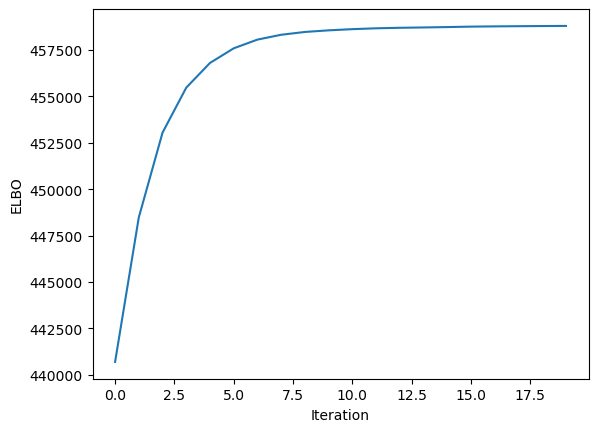

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.86it/s]


ELBO: 349332.89664146793
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 73.03it/s]


ELBO: 349396.86145007407
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.93it/s]


ELBO: 349452.00311205426
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 74.07it/s]


ELBO: 349490.56053787295
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.85it/s]


ELBO: 349515.6629570702
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.03it/s]


ELBO: 349532.1638553234
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.15it/s]


ELBO: 349543.5173261541
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 69.51it/s]


ELBO: 349551.77800070075
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.72it/s]


ELBO: 349557.85477271036
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 67.99it/s]


ELBO: 349561.8659783315
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.69it/s]


ELBO: 349564.7296763989
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.51it/s]


ELBO: 349566.85821375344
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.55it/s]


ELBO: 349568.4528756471
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.79it/s]


ELBO: 349569.6560446697
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.89it/s]


ELBO: 349570.5696778566
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.53it/s]


ELBO: 349571.26751602907
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.47it/s]


ELBO: 349571.80337980896
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 73.08it/s]


ELBO: 349572.2168790555
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.13it/s]


ELBO: 349572.53738839447
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 74.70it/s]


ELBO: 349572.7868453056
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 8725.41it/s]

Predictive likelihood: -2809.115874846394
Total run-time: 0:0:8


<Figure size 640x480 with 0 Axes>

In [105]:
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.01

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [106]:
theta1 = [LAMBDA_final, GAMMA_final, PHI_final] 

Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.50it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1920.56it/s]


ELBO: 440684.6148471351
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.45it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2044.51it/s]


ELBO: 448492.65833333635
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.81it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2304.69it/s]


ELBO: 453048.9012982161
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.09it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2028.78it/s]


ELBO: 455419.69097795704
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.30it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2166.93it/s]


ELBO: 456814.967436007
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.79it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2018.14it/s]


ELBO: 457574.5319634402
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.53it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2072.90it/s]


ELBO: 458019.50313759595
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.81it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2091.61it/s]


ELBO: 458304.16583496484
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.95it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2004.45it/s]


ELBO: 458493.8667122563
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2022.23it/s]


ELBO: 458605.0417210224
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2111.94it/s]


ELBO: 458675.8088047522
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.96it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2012.82it/s]


ELBO: 458717.1553886126
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.81it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2103.57it/s]


ELBO: 458738.573374208
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.57it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2083.30it/s]


ELBO: 458750.2085281356
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.68it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


ELBO: 458764.2738626289
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.01it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2164.47it/s]


ELBO: 458770.53288504493
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.24it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1950.75it/s]


ELBO: 458776.2844483925
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.25it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2257.92it/s]


ELBO: 458782.4076634218
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.56it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2036.66it/s]


ELBO: 458792.43010691414
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2038.35it/s]


ELBO: 458802.9954365284


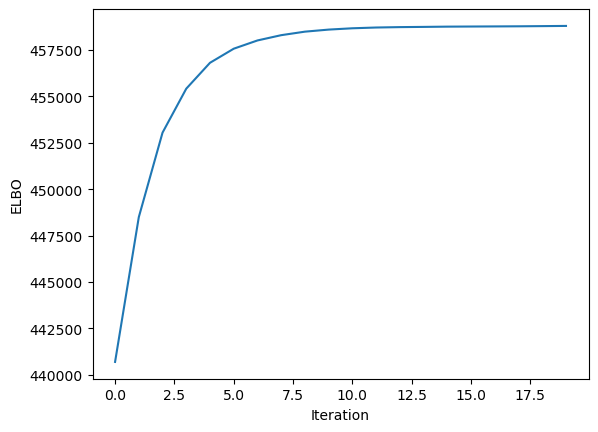

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.18it/s]


ELBO: 349331.53852981067
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 67.80it/s]


ELBO: 349412.42648445454
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.30it/s]


ELBO: 349488.30866055813
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 67.39it/s]


ELBO: 349546.2493961502
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 69.53it/s]


ELBO: 349587.800360117
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.44it/s]


ELBO: 349616.43533587235
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.68it/s]


ELBO: 349636.9968377414
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.48it/s]


ELBO: 349651.87230145774
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.98it/s]


ELBO: 349662.4702471467
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.53it/s]


ELBO: 349669.8018757633
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.16it/s]


ELBO: 349675.08220736723
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.54it/s]


ELBO: 349679.03559350414
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 73.54it/s]


ELBO: 349682.0162362648
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.28it/s]


ELBO: 349684.2780493906
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 72.07it/s]


ELBO: 349686.00494455703
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.37it/s]


ELBO: 349687.33109861333
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 71.47it/s]


ELBO: 349688.3551046891
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.83it/s]


ELBO: 349689.14991061593
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 70.53it/s]


ELBO: 349689.7698470599
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 73.09it/s]


ELBO: 349690.2556340879
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 7147.76it/s]

Predictive likelihood: -2829.152617277861
Total run-time: 0:0:17


<Figure size 640x480 with 0 Axes>

In [107]:
'''
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.01

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]
'''

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [108]:
theta2 = [LAMBDA_final, GAMMA_final, PHI_final] 

### what are the most probable words? 

theta1

In [86]:
most_freq_words_1 = [] 

for k in range(C): 
  row = theta1[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_1.append(words)

theta2 

In [ ]:
most_freq_words_2 = [] 

for k in range(C): 
  row = theta2[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_2.append(words)

In [ ]:
most_freq_words_2

## CHONG

In [137]:
T = 100
N = 7
p_list = init(theta1, theta2, N)
k = 0.001
lr = 0.3

In [138]:
import copy
His = []

In [139]:
for t in range (T):
    print("iter ", t) 
    for i in range (1,N):
        print(i)
        F_L_lmbda, F_L_gamma, F_L_phi = F_L(i, p_list,train_articles, train_nonzero_idxs, C) 
        F_s_lmbda, F_s_gamma, F_s_phi = F_s(i, k, p_list)
        LAMBDA, GAMMA, PHI = p_list[i] 

        LAMBDA = LAMBDA + lr * (-F_L_lmbda + F_s_lmbda)
        GAMMA = GAMMA + lr * (-F_L_gamma + F_s_gamma)
        PHI = [phi + lr * (-f_l_phi + f_s_phi) for (phi, f_l_phi, f_s_phi) in zip(PHI, F_L_phi, F_s_phi)]
        p_list[i] = [LAMBDA, GAMMA, PHI ]
    His.append(copy.deepcopy(p_list))

iter  0
1
ELBO: 455221.5407381431
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.84it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2200.12it/s]


2
ELBO: 454933.2794657599
ELBO: 456157.314625734


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.93it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1526.09it/s]


3
ELBO: 454931.6600418745
ELBO: 455420.4761797897


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.22it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1581.03it/s]


4
ELBO: 455217.1472015117
ELBO: 455027.6563235975


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1825.75it/s]


5
ELBO: 455860.73089582636
ELBO: 455021.04599456786


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1822.82it/s]


6
ELBO: 458802.9954365284
ELBO: 455410.9816148037


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2008.48it/s]


iter  1
1
ELBO: 455420.4761797897
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.35it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1724.06it/s]


2
ELBO: 455027.6563235975
ELBO: 456451.1737822563


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.48it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1727.40it/s]


3
ELBO: 455021.04599456786
ELBO: 455657.17397886683


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.68it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1953.56it/s]


4
ELBO: 455410.9816148037
ELBO: 455168.2799776032


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1958.49it/s]


5
ELBO: 456151.58994079276
ELBO: 455152.07447045535


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.42it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1968.14it/s]


6
ELBO: 458802.9954365284
ELBO: 455642.57623391517


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.31it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1975.84it/s]


iter  2
1
ELBO: 455657.17397886683
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.89it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1673.37it/s]


2
ELBO: 455168.2799776032
ELBO: 456740.01242314087


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.87it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1863.64it/s]


3
ELBO: 455152.07447045535
ELBO: 455919.6089644983


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.38it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1923.82it/s]


4
ELBO: 455642.57623391517
ELBO: 455356.7994886119


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.32it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1977.79it/s]


5
ELBO: 456446.3907864045
ELBO: 455327.09576244844


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.84it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1876.39it/s]


6
ELBO: 458802.9954365284
ELBO: 455900.192069818


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.63it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2168.16it/s]


iter  3
1
ELBO: 455919.6089644983
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.52it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1906.16it/s]


2
ELBO: 455356.7994886119
ELBO: 457018.65737914306


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.08it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2065.24it/s]


3
ELBO: 455327.09576244844
ELBO: 456195.6838494541


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.52it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2092.03it/s]


4
ELBO: 455900.192069818
ELBO: 455585.5629873759


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.15it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1914.86it/s]


5
ELBO: 456737.28544101206
ELBO: 455540.0198177304


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.15it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1965.74it/s]


6
ELBO: 458802.9954365284
ELBO: 456171.61970362137


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1773.04it/s]


iter  4
1
ELBO: 456195.6838494541
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2040.83it/s]


2
ELBO: 455585.5629873759
ELBO: 457282.5961536811


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.73it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1915.73it/s]


3
ELBO: 455540.0198177304
ELBO: 456476.13690891705


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.30it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2083.71it/s]


4
ELBO: 456171.61970362137
ELBO: 455842.2815272956


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.44it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1841.30it/s]


5
ELBO: 457018.76375987835
ELBO: 455780.3077184235


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.29it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1774.02it/s]


6
ELBO: 458802.9954365284
ELBO: 456447.6655163435


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.62it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2297.75it/s]


iter  5
1
ELBO: 456476.13690891705
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.97it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1953.11it/s]


2
ELBO: 455842.2815272956
ELBO: 457527.69653426233


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.05it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1940.55it/s]


3
ELBO: 455780.3077184235
ELBO: 456754.0476696483


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.39it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2109.17it/s]


4
ELBO: 456447.6655163435
ELBO: 456115.276630053


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.98it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1885.00it/s]


5
ELBO: 457285.92706371367
ELBO: 456037.25362993754


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.37it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2096.42it/s]


6
ELBO: 458802.9954365284
ELBO: 456721.81075788167


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.51it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1983.69it/s]


iter  6
1
ELBO: 456754.0476696483
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.70it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1680.95it/s]


2
ELBO: 456115.276630053
ELBO: 457750.4092364892


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.40it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1898.99it/s]


3
ELBO: 456037.25362993754
ELBO: 457023.5411486134


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1917.22it/s]


4
ELBO: 456721.81075788167
ELBO: 456395.648913758


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.19it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1922.67it/s]


5
ELBO: 457534.3098508018
ELBO: 456302.2866145566


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.33it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2004.73it/s]


6
ELBO: 458802.9954365284
ELBO: 456988.4956567998


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2025.94it/s]


iter  7
1
ELBO: 457023.5411486134
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.60it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2198.27it/s]


2
ELBO: 456395.648913758
ELBO: 457948.11846361274


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.19it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2140.82it/s]


3
ELBO: 456302.2866145566
ELBO: 457279.5729160705


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.89it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2191.04it/s]


4
ELBO: 456988.4956567998
ELBO: 456676.53885397455


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.00it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2052.61it/s]


5
ELBO: 457760.0833122657
ELBO: 456569.01259180164


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.06it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2060.58it/s]


6
ELBO: 458802.9954365284
ELBO: 457242.44370327704


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.53it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1979.38it/s]


iter  8
1
ELBO: 457279.5729160705
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.28it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1757.81it/s]


2
ELBO: 456676.53885397455
ELBO: 458119.3999690314


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2128.55it/s]


3
ELBO: 456569.01259180164
ELBO: 457518.0187076028


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.88it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1884.66it/s]


4
ELBO: 457242.44370327704
ELBO: 456952.42894331866


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.86it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1792.13it/s]


5
ELBO: 457960.3899833772
ELBO: 456832.5431636876


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.56it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1871.62it/s]


6
ELBO: 458802.9954365284
ELBO: 457478.98836741375


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1886.44it/s]


iter  9
1
ELBO: 457518.0187076028
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.26it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1973.98it/s]


2
ELBO: 456952.42894331866
ELBO: 458264.2608059344


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.61it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1705.56it/s]


3
ELBO: 456832.5431636876
ELBO: 457735.5238944945


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1936.52it/s]


4
ELBO: 457478.98836741375
ELBO: 457218.87083118595


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.22it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1738.79it/s]


5
ELBO: 458133.6959490133
ELBO: 457088.78730347863


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.99it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2032.91it/s]


6
ELBO: 458802.9954365284
ELBO: 457694.4467278258


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.09it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2085.16it/s]


iter  10
1
ELBO: 457735.5238944945
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2275.80it/s]


2
ELBO: 457218.87083118595
ELBO: 458384.13554226095


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.34it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1947.40it/s]


3
ELBO: 457088.78730347863
ELBO: 457929.8156523699


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.34it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1892.22it/s]


4
ELBO: 457694.4467278258
ELBO: 457472.131477599


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.93it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2223.21it/s]


5
ELBO: 458279.976761992
ELBO: 457333.8808333834


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.38it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1674.77it/s]


6
ELBO: 458802.9954365284
ELBO: 457886.45765110716


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.23it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1793.66it/s]


iter  11
1
ELBO: 457929.8156523699
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.84it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2069.52it/s]


2
ELBO: 457472.131477599
ELBO: 458481.5409019699


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.45it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1899.25it/s]


3
ELBO: 457333.8808333834
ELBO: 458100.05374868924


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.70it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2191.04it/s]


4
ELBO: 457886.45765110716
ELBO: 457708.94442039484


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.18it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2130.39it/s]


5
ELBO: 458400.634783531
ELBO: 457564.31308097485


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 67.89it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2058.05it/s]


6
ELBO: 458802.9954365284
ELBO: 458054.19166055974


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.47it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2166.82it/s]


iter  12
1
ELBO: 458100.05374868924
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.71it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2060.17it/s]


2
ELBO: 457708.94442039484
ELBO: 458559.5759424723


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.50it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1731.04it/s]


3
ELBO: 457564.31308097485
ELBO: 458246.7663574986


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.73it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1989.61it/s]


4
ELBO: 458054.19166055974
ELBO: 457926.5088595197


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.26it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2145.97it/s]


5
ELBO: 458498.1416406272
ELBO: 457777.3401640211


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.29it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2079.48it/s]


6
ELBO: 458802.9954365284
ELBO: 458198.2178290198


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.20it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.72it/s]


iter  13
1
ELBO: 458246.7663574986
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.22it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2082.57it/s]


2
ELBO: 457926.5088595197
ELBO: 458621.42673032376


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.37it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1820.21it/s]


3
ELBO: 457777.3401640211
ELBO: 458371.51529161073


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.58it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2174.79it/s]


4
ELBO: 458198.2178290198
ELBO: 458122.75615255395


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.96it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1728.61it/s]


5
ELBO: 458575.5711583274
ELBO: 457971.10099886206


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.04it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2160.23it/s]


6
ELBO: 458802.9954365284
ELBO: 458320.15765370545


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.24it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2144.55it/s]


iter  14
1
ELBO: 458371.51529161073
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.31it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2076.29it/s]


2
ELBO: 458122.75615255395
ELBO: 458670.0354776702


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.61it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1876.23it/s]


3
ELBO: 457971.10099886206
ELBO: 458476.4803877516


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.23it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1866.46it/s]


4
ELBO: 458320.15765370545
ELBO: 458296.7041382011


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.97it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2004.45it/s]


5
ELBO: 458636.180814649
ELBO: 458144.57806712575


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.26it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1895.05it/s]


6
ELBO: 458802.9954365284
ELBO: 458422.2922597518


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.05it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1988.95it/s]


iter  15
1
ELBO: 458476.4803877516
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.35it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2083.30it/s]


2
ELBO: 458296.7041382011
ELBO: 458708.02086899953


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.81it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1883.98it/s]


3
ELBO: 458144.57806712575
ELBO: 458564.09809897316


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.13it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1567.14it/s]


4
ELBO: 458422.2922597518
ELBO: 458448.56919361406


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.59it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1886.86it/s]


5
ELBO: 458683.0940366301
ELBO: 458297.6331953384


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.83it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2134.94it/s]


6
ELBO: 458802.9954365284
ELBO: 458507.16221481864


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.22it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2176.71it/s]


iter  16
1
ELBO: 458564.09809897316
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1724.35it/s]


2
ELBO: 458448.56919361406
ELBO: 458737.62887124496


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.55it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2166.93it/s]


3
ELBO: 458297.6331953384
ELBO: 458636.82370968553


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.29it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1811.32it/s]


4
ELBO: 458507.16221481864
ELBO: 458579.5250347609


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.00it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2163.46it/s]


5
ELBO: 458719.10000708955
ELBO: 458430.96023659286


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.61it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1977.51it/s]


6
ELBO: 458802.9954365284
ELBO: 458577.27121820487


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.14it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2034.59it/s]


iter  17
1
ELBO: 458636.82370968553
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.81it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


2
ELBO: 458579.5250347609
ELBO: 458760.7197495283


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.50it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2014.56it/s]


3
ELBO: 458430.96023659286
ELBO: 458697.0543572213


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.95it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2080.20it/s]


4
ELBO: 458577.27121820487
ELBO: 458691.2977407482


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.56it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2074.54it/s]


5
ELBO: 458746.570800136
ELBO: 458545.9118977205


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2029.27it/s]


6
ELBO: 458802.9954365284
ELBO: 458634.9502312948


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.83it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1819.50it/s]


iter  18
1
ELBO: 458697.0543572213
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.28it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2077.73it/s]


2
ELBO: 458691.2977407482
ELBO: 458778.7895619564


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.33it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2192.53it/s]


3
ELBO: 458545.9118977205
ELBO: 458747.0202780826


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1993.96it/s]


4
ELBO: 458634.9502312948
ELBO: 458785.81678081455


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.95it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1905.12it/s]


5
ELBO: 458767.46029017714
ELBO: 458644.2056392426


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.25it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1778.38it/s]


6
ELBO: 458802.9954365284
ELBO: 458682.3171656506


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2138.10it/s]


iter  19
1
ELBO: 458747.0202780826
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.47it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1956.21it/s]


2
ELBO: 458785.81678081455
ELBO: 458793.01351291727


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.18it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2117.80it/s]


3
ELBO: 458644.2056392426
ELBO: 458788.5432546695


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.52it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2104.94it/s]


4
ELBO: 458682.3171656506
ELBO: 458865.1565028019


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.95it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2245.71it/s]


5
ELBO: 458783.3383630996
ELBO: 458727.6778749168


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.02it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1961.15it/s]


6
ELBO: 458802.9954365284
ELBO: 458721.24785564555


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.78it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1892.82it/s]


iter  20
1
ELBO: 458788.5432546695
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.27it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1723.85it/s]


2
ELBO: 458865.1565028019
ELBO: 458804.30198056664


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.98it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2031.63it/s]


3
ELBO: 458727.6778749168
ELBO: 458823.1741420961


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.83it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2111.51it/s]


4
ELBO: 458721.24785564555
ELBO: 458931.3294380507


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.75it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1964.64it/s]


5
ELBO: 458795.43666443805
ELBO: 458798.16831388924


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.14it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1954.66it/s]


6
ELBO: 458802.9954365284
ELBO: 458753.3598048534


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.55it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1770.65it/s]


iter  21
1
ELBO: 458823.1741420961
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.02it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2089.53it/s]


2
ELBO: 458931.3294380507
ELBO: 458813.3743312486


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.35it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2155.68it/s]


3
ELBO: 458798.16831388924
ELBO: 458852.18337208737


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.02it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2009.63it/s]


4
ELBO: 458753.3598048534
ELBO: 458986.16186312545


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.85it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2174.90it/s]


5
ELBO: 458804.6984809581
ELBO: 458857.40618958895


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2325.78it/s]


6
ELBO: 458802.9954365284
ELBO: 458780.0084698284


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.08it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1865.71it/s]


iter  22
1
ELBO: 458852.18337208737
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2119.94it/s]


2
ELBO: 458986.16186312545
ELBO: 458820.7549017433


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.83it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2087.24it/s]


3
ELBO: 458857.40618958895
ELBO: 458876.6270292992


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.77it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2181.01it/s]


4
ELBO: 458780.0084698284
ELBO: 459031.3722650792


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.82it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2351.20it/s]


5
ELBO: 458811.8334828849
ELBO: 458906.96714327816


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.85it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1946.31it/s]


6
ELBO: 458802.9954365284
ELBO: 458802.30697299493


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.36it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1728.90it/s]


iter  23
1
ELBO: 458876.6270292992
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.18it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2073.82it/s]


2
ELBO: 459031.3722650792
ELBO: 458826.824446607


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.99it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2048.80it/s]


3
ELBO: 458906.96714327816
ELBO: 458897.32547329436


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.12it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2397.43it/s]


4
ELBO: 458802.30697299493
ELBO: 459068.4783431744


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 68.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1757.22it/s]


5
ELBO: 458817.37227744
ELBO: 458948.28830989986


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.79it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1570.61it/s]


6
ELBO: 458802.9954365284
ELBO: 458821.1436227988


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.04it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1876.14it/s]


iter  24
1
ELBO: 458897.32547329436
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.58it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2171.98it/s]


2
ELBO: 459068.4783431744
ELBO: 458831.86002761865


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.47it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2154.79it/s]


3
ELBO: 458948.28830989986
ELBO: 458914.94554465066


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.98it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2065.65it/s]


4
ELBO: 458821.1436227988
ELBO: 459098.83264984837


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.07it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1804.62it/s]


5
ELBO: 458821.75796597963
ELBO: 458982.6987189419


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.75it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2163.57it/s]


6
ELBO: 458802.9954365284
ELBO: 458837.2134142319


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.27it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1943.61it/s]


iter  25
1
ELBO: 458914.94554465066
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2025.94it/s]


2
ELBO: 459098.83264984837
ELBO: 458836.07793937036


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.86it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1905.46it/s]


3
ELBO: 458982.6987189419
ELBO: 458930.0203772598


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.06it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1909.11it/s]


4
ELBO: 458837.2134142319
ELBO: 459123.62817657576


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.78it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1762.39it/s]


5
ELBO: 458825.24756557064
ELBO: 459011.37277654937


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.49it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1929.75it/s]


6
ELBO: 458802.9954365284
ELBO: 458851.07024145784


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.12it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1867.37it/s]


iter  26
1
ELBO: 458930.0203772598
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.44it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2078.14it/s]


2
ELBO: 459123.62817657576
ELBO: 458839.64670665434


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.78it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1983.69it/s]


3
ELBO: 459011.37277654937
ELBO: 458942.97381649964


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.60it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1822.50it/s]


4
ELBO: 458851.07024145784
ELBO: 459143.90724350436


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.35it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1880.43it/s]


5
ELBO: 458828.0574902495
ELBO: 459035.3386039743


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.32it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1895.64it/s]


6
ELBO: 458802.9954365284
ELBO: 458863.1669180607


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.30it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1967.40it/s]


iter  27
1
ELBO: 458942.97381649964
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1675.31it/s]


2
ELBO: 459143.90724350436
ELBO: 458842.688569303


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.30it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2074.74it/s]


3
ELBO: 459035.3386039743
ELBO: 458954.16288508347


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1956.21it/s]


4
ELBO: 458863.1669180607
ELBO: 459160.58597830497


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.03it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1927.53it/s]


5
ELBO: 458830.3451986422
ELBO: 459055.48391517013


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2104.52it/s]


6
ELBO: 458802.9954365284
ELBO: 458873.84621282795


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.22it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2063.72it/s]


iter  28
1
ELBO: 458954.16288508347
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 70.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1719.40it/s]


2
ELBO: 459160.58597830497
ELBO: 458845.3042357567


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.97it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2032.52it/s]


3
ELBO: 459055.48391517013
ELBO: 458963.87679307297


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.34it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2190.92it/s]


4
ELBO: 458873.84621282795
ELBO: 459174.4260800797


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.45it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2225.80it/s]


5
ELBO: 458832.22707422206
ELBO: 459072.5359533512


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.03it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2128.98it/s]


6
ELBO: 458802.9954365284
ELBO: 458883.3714024267


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.44it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2181.01it/s]


iter  29
1
ELBO: 458963.87679307297
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.01it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2035.77it/s]


2
ELBO: 459174.4260800797
ELBO: 458847.56860557024


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.35it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2236.84it/s]


3
ELBO: 459072.5359533512
ELBO: 458972.35835115105


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1946.31it/s]


4
ELBO: 458883.3714024267
ELBO: 459186.00520386256


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 75.19it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2188.52it/s]


5
ELBO: 458833.78934164613
ELBO: 459087.09986659547


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.87it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2109.60it/s]


6
ELBO: 458802.9954365284
ELBO: 458891.9517142243


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.75it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1944.42it/s]


iter  30
1
ELBO: 458972.35835115105
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.84it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.35it/s]


2
ELBO: 459186.00520386256
ELBO: 458849.5348982566


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.31it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2146.85it/s]


3
ELBO: 459087.09986659547
ELBO: 458979.80499750754


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.42it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1921.26it/s]


4
ELBO: 458891.9517142243
ELBO: 459195.76550253475


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1900.80it/s]


5
ELBO: 458835.10112238594
ELBO: 459099.706786764


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.91it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2010.02it/s]


6
ELBO: 458802.9954365284
ELBO: 458899.74305909825


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.12it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2037.16it/s]


iter  31
1
ELBO: 458979.80499750754
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.92it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2101.35it/s]


2
ELBO: 459195.76550253475
ELBO: 458851.24408584554


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.55it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2183.85it/s]


3
ELBO: 459099.706786764
ELBO: 458986.41360446805


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 71.80it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1724.77it/s]


4
ELBO: 458899.74305909825
ELBO: 459204.03729044093


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.28it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2037.55it/s]


5
ELBO: 458836.21262857085
ELBO: 459110.8882812874


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 72.32it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1857.37it/s]


6
ELBO: 458802.9954365284
ELBO: 458906.86368434486


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.67it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2157.45it/s]


iter  32
1
ELBO: 458986.41360446805
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.72it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2119.08it/s]


2
ELBO: 459204.03729044093
ELBO: 458852.73408270587


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.57it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2196.89it/s]


3
ELBO: 459110.8882812874
ELBO: 458992.4562972261


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.78it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1965.01it/s]


4
ELBO: 458906.86368434486
ELBO: 459211.09610036353


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.42it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2063.92it/s]


5
ELBO: 458837.1600888169
ELBO: 459121.5169577791


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.03it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


6
ELBO: 458802.9954365284
ELBO: 458913.4017060094


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 73.02it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2025.84it/s]


iter  33
1
ELBO: 458992.4562972261
ELBO: 458794.7425660929


100%|███████████████████████████████████████████████| 12/12 [00:00<00:00, 74.17it/s]


Updating LAMBDA


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 2094.74it/s]


2
ELBO: 459211.09610036353
ELBO: 458854.05070231005


  8%|████                                            | 1/12 [00:00<00:00, 40.55it/s]


FloatingPointError: underflow encountered in exp

In [140]:
total_ELBO_list = []
for his in His:
    ELBO_list = []
    for p in his: 
        LAMBDA, GAMMA, PHI = p 
        elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
        ELBO_list.append(elbo) 
    total_ELBO_list.append(ELBO_list)

ELBO: 458794.7425660929
ELBO: 456157.314625734
ELBO: 455420.4761797897
ELBO: 455027.6563235975
ELBO: 455021.04599456786
ELBO: 455410.9816148037
ELBO: 456151.58994079276
ELBO: 458802.9954365284
ELBO: 458794.7425660929
ELBO: 456451.1737822563
ELBO: 455657.17397886683
ELBO: 455168.2799776032
ELBO: 455152.07447045535
ELBO: 455642.57623391517
ELBO: 456446.3907864045
ELBO: 458802.9954365284
ELBO: 458794.7425660929
ELBO: 456740.01242314087
ELBO: 455919.6089644983
ELBO: 455356.7994886119
ELBO: 455327.09576244844
ELBO: 455900.192069818
ELBO: 456737.28544101206
ELBO: 458802.9954365284
ELBO: 458794.7425660929
ELBO: 457018.65737914306
ELBO: 456195.6838494541
ELBO: 455585.5629873759
ELBO: 455540.0198177304
ELBO: 456171.61970362137
ELBO: 457018.76375987835
ELBO: 458802.9954365284
ELBO: 458794.7425660929
ELBO: 457282.5961536811
ELBO: 456476.13690891705
ELBO: 455842.2815272956
ELBO: 455780.3077184235
ELBO: 456447.6655163435
ELBO: 457285.92706371367
ELBO: 458802.9954365284
ELBO: 458794.7425660929
ELBO:

ELBO: 458794.7425660929
ELBO: 455866.02214595163
ELBO: 455221.5407381431
ELBO: 454933.2794657599
ELBO: 454931.6600418745
ELBO: 455217.1472015117
ELBO: 455860.73089582636
ELBO: 458802.9954365284


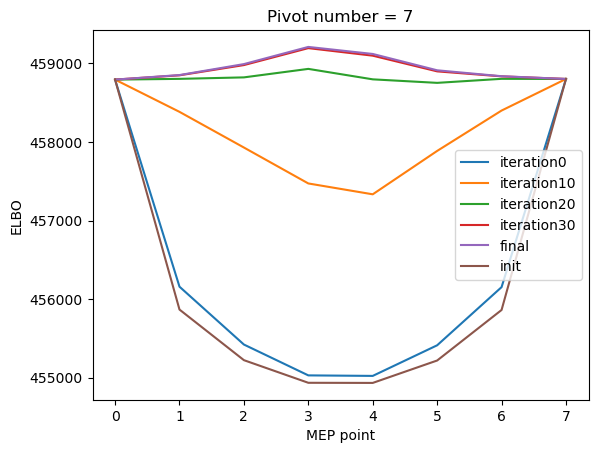

In [141]:
for i in range(len(total_ELBO_list)):
    if i % 10 == 0:
        plt.plot(total_ELBO_list[i], label = 'iteration{}'.format(i))
        
plt.plot(total_ELBO_list[-1], label = 'final')
p_list_init = init(theta1, theta2, N)
ELBO_list_init = []
for p in p_list_init: 
    LAMBDA, GAMMA, PHI = p 
    elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
    ELBO_list_init.append(elbo) 
plt.plot(ELBO_list_init ,label = 'init')
plt.xlabel("MEP point") 
plt.ylabel("ELBO")
plt.title("Pivot number = {}".format(N))
plt.legend()
plt.savefig(PATH + '/Result/p_7', dpi=600, facecolor='w', transparent=True)

### contour plot 

Dimensionality reduction of parameters into 2d 
- choose two orthogonal random directions in high dimension and project onto these two dimensions to obtain a 2d embedding

In [58]:
p_list = His[-1]

## Normal

In [59]:
LAMBDA, GAMMA, PHI = theta1

norm_1 = 0
d1_LAMBDA = np.random.normal(0, 1, LAMBDA.shape)
norm_1 += np.square(np.linalg.norm(d1_LAMBDA)) 
d1_GAMMA = np.random.normal(0, 1, GAMMA.shape)
norm_1 += np.square(np.linalg.norm(d1_GAMMA)) 
d1_PHI = [np.random.normal(0, 1, i.shape) for i in PHI]

for d1_phi in d1_PHI:
    norm_1 += np.square(np.linalg.norm(d1_phi)) 

norm_1 = np.sqrt(norm_1)
d1_LAMBDA /= norm_1 
d1_GAMMA /= norm_1 
d1_PHI = [d1_phi/norm_1 for d1_phi in d1_PHI]

norm_2 = 0

d2_LAMBDA = np.random.normal(0, 1, LAMBDA.shape)
norm_2 += np.square(np.linalg.norm(d2_LAMBDA)) 
d2_GAMMA = np.random.normal(0, 1, GAMMA.shape)
norm_2 += np.square(np.linalg.norm(d2_GAMMA)) 
d2_PHI = [np.random.normal(0, 1, i.shape) for i in PHI]

for d2_phi in d1_PHI:
    norm_2 += np.square(np.linalg.norm(d2_phi)) 

norm_2 = np.sqrt(norm_2)
d2_LAMBDA /= norm_2 
d2_GAMMA /= norm_2
d2_PHI = [d2_phi / norm_2 for d2_phi in d2_PHI]  

center = init(theta1, theta2, N = 2)[1]
center_LAMBDA, center_GAMMA, center_PHI = center

    
def projection(pp_list, center):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))

    center_LAMBDA, center_GAMMA, center_PHI = center

    for i in range(len(pp_list)):
        LAMBDA, GAMMA, PHI = pp_list[i]
        LAMBDA_P = LAMBDA - center_LAMBDA
        x_list[i] += np.sum(d1_LAMBDA * LAMBDA_P)
        GAMMA_P = GAMMA - center_GAMMA
        x_list[i] += np.sum(d1_GAMMA * GAMMA_P)
        PHI_P = [phi - center_phi for (center_phi, phi) in zip(center_PHI, PHI)]
        x_list[i] += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

        y_list[i] += np.sum(d2_LAMBDA * LAMBDA_P)
        y_list[i] += np.sum(d2_GAMMA * GAMMA_P)
        y_list[i] += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x_list, y_list



## Bern

In [66]:
LAMBDA, GAMMA, PHI = theta1

norm_1 = 0
d1_LAMBDA = np.random.binomial(1, 0.5, LAMBDA.shape).astype(float)
d2_LAMBDA = np.ones(LAMBDA.shape) - d1_LAMBDA

d1_GAMMA = np.random.binomial(1, 0.5, GAMMA.shape).astype(float)
d2_GAMMA = np.ones(GAMMA.shape) - d1_GAMMA

d1_PHI = [np.random.binomial(1, 0.5, i.shape).astype(float) for i in PHI]
d2_PHI = [np.ones(i.shape) - i for i in d1_PHI]



norm_1 += np.square(np.linalg.norm(d1_LAMBDA))
norm_1 += np.square(np.linalg.norm(d1_GAMMA)) 


for d1_phi in d1_PHI:
    norm_1 += np.square(np.linalg.norm(d1_phi)) 

norm_1 = np.sqrt(norm_1)
d1_LAMBDA /= norm_1 
d1_GAMMA /= norm_1 
d1_PHI = [d1_phi/norm_1 for d1_phi in d1_PHI]

norm_2 = 0

norm_2 += np.square(np.linalg.norm(d2_LAMBDA)) 
norm_2 += np.square(np.linalg.norm(d2_GAMMA)) 

for d2_phi in d1_PHI:
    norm_2 += np.square(np.linalg.norm(d2_phi)) 

norm_2 = np.sqrt(norm_2)
d2_LAMBDA /= norm_2 
d2_GAMMA /= norm_2
d2_PHI = [d2_phi / norm_2 for d2_phi in d2_PHI]  

center = init(theta1, theta2, N = 2)[1]
center_LAMBDA, center_GAMMA, center_PHI = center

    
def projection(pp_list, center):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))

    center_LAMBDA, center_GAMMA, center_PHI = center

    for i in range(len(pp_list)):
        LAMBDA, GAMMA, PHI = pp_list[i]
        LAMBDA_P = LAMBDA - center_LAMBDA
        x_list[i] += np.sum(d1_LAMBDA * LAMBDA_P)
        GAMMA_P = GAMMA - center_GAMMA
        x_list[i] += np.sum(d1_GAMMA * GAMMA_P)
        PHI_P = [phi - center_phi for (center_phi, phi) in zip(center_PHI, PHI)]
        x_list[i] += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

        y_list[i] += np.sum(d2_LAMBDA * LAMBDA_P)
        y_list[i] += np.sum(d2_GAMMA * GAMMA_P)
        y_list[i] += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x_list, y_list

def point_projection(point):

    LAMBDA_P, GAMMA_P, PHI_P = point
    x = 0
    y = 0

    x += np.sum(d1_LAMBDA * LAMBDA_P)
    x += np.sum(d1_GAMMA * GAMMA_P)
    x += np.sum(np.array([np.sum(d1_phi * phi_p) for (d1_phi, phi_p) in zip(d1_PHI, PHI_P)]))

    y += np.sum(d2_LAMBDA * LAMBDA_P)
    y += np.sum(d2_GAMMA * GAMMA_P)
    y += np.sum(np.array([np.sum(d2_phi * phi_p) for (d2_phi, phi_p) in zip(d2_PHI, PHI_P)]))
        
    return x, y

def line_projection(pp_list):
    x_list = np.zeros(len(pp_list))
    y_list = np.zeros(len(pp_list))
    
    for i in range(len(pp_list)):
        x_list[i],y_list[i] = point_projection(pp_list[i])
        
    return x_list, y_list

In [67]:
precision = 10
extend = precision / 2
loss_surface = np.zeros((precision+1,precision+1))
h_list = np.arange(-extend,extend+1,1) / 10
v_list = np.arange(-extend,extend+1,1) / 10

for i in range(precision+1):
    for j in range(precision+1): 
        print('i: ',i)
        print('j: ',j)
        d1 = h_list[i]
        d2 = v_list[j]
        NEW_LAMBDA = center_LAMBDA + d1 * d1_LAMBDA + d2 * d2_LAMBDA
        NEW_GAMMA = center_GAMMA + d1 * d1_GAMMA + d2 * d2_GAMMA
        NEW_PHI = [center_phi + d1 * d1_phi + d2 * d2_phi for (center_phi, d1_phi,d2_phi) in zip(center_PHI, d1_PHI , d2_PHI)]
        loss_surface[i,j] = compute_elbo(NEW_LAMBDA, NEW_GAMMA, NEW_PHI,train_articles, train_nonzero_idxs, C)

#TODO 
#plot loss_surface 


#TODO 
#plots points (p_list) on the loss surface by first centering the points and then projecting them onto d1 and d2 

i:  0
j:  0
ELBO: 456058.4653680886
i:  0
j:  1
ELBO: 456184.2798593177
i:  0
j:  2
ELBO: 456138.01014112576
i:  0
j:  3
ELBO: 455951.32621486316
i:  0
j:  4
ELBO: 455649.9033538906
i:  0
j:  5
ELBO: 455256.8968334715
i:  0
j:  6
ELBO: 454783.901812315
i:  0
j:  7
ELBO: 454239.58381617215
i:  0
j:  8
ELBO: 453637.9556349994
i:  0
j:  9
ELBO: 452988.8080127389
i:  0
j:  10
ELBO: 452300.0746958321
i:  1
j:  0
ELBO: 456123.64055779646
i:  1
j:  1
ELBO: 456270.9471499315
i:  1
j:  2
ELBO: 456245.0895332282
i:  1
j:  3
ELBO: 456077.8924094697
i:  1
j:  4
ELBO: 455795.15751350333
i:  1
j:  5
ELBO: 455420.14450699947
i:  1
j:  6
ELBO: 454964.5354767345
i:  1
j:  7
ELBO: 454437.06892283336
i:  1
j:  8
ELBO: 453851.8193487594
i:  1
j:  9
ELBO: 453218.63004347647
i:  1
j:  10
ELBO: 452545.4797724917
i:  2
j:  0
ELBO: 456045.1405101859
i:  2
j:  1
ELBO: 456212.9417813074
i:  2
j:  2
ELBO: 456206.498899335
i:  2
j:  3
ELBO: 456057.79126462387
i:  2
j:  4
ELBO: 455792.74707174033
i:  2
j:  5
ELBO: 

In [68]:
center_x, center_y = point_projection(center)
v_list += center_y
h_list += center_x

p_list_init = init(theta1, theta2, N)
init_x,init_y = line_projection(p_list_init)
x_list, y_list = line_projection(p_list)

In [69]:
elbo_init = []
for p in p_list_init: 
    LAMBDA, GAMMA, PHI = p 
    elbo_init.append(compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C))

ELBO: 458783.22785163455
ELBO: 456137.9919172468
ELBO: 455486.6660985581
ELBO: 455110.4034683276
ELBO: 454895.65659437934
ELBO: 454822.9126512114
ELBO: 454890.2845641394
ELBO: 455098.81076691323
ELBO: 455467.0538670933
ELBO: 456107.04028626776
ELBO: 458729.44917165855


In [70]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

x = x_list
y = y_list
z = total_ELBO_list[-1]
color1=["b" for i in range(len(x_list))]
df = pd.DataFrame({"x": x, "y":y, "z":z, "color":color1})

fig1 = px.line_3d(df, x="x", y="y", z="z", color="color" ,color_discrete_map={ "a": "RebeccaPurple"})

x2 = init_x
y2 = init_y
z2 = elbo_init
df = pd.DataFrame({"x": x2, "y":y2, "z":z2})

fig2 = px.line_3d(df, x="x", y="y", z="z")

fig3 = go.Figure(data=[go.Surface(x=h_list, y=v_list, z=loss_surface)])

fig = go.Figure(data = fig1.data + fig2.data +fig3.data)
fig.show()

In [75]:
len(His)

100

### out of sample performance


In [76]:
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim = 1)
test_articles = articles[-10:]
test_nonzero_idxs = nonzero_idxs[-10:]

/var/folders/mw/9bfg1rf52g57tm0mgxqjy4gm0000gn/T/ipykernel_4130/2775555696.py:22: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Loading index-to-word mapping...
Loading article bag-of-word representations...
2246 articles found.


100%|████████████████████████████████████████| 2246/2246 [00:00<00:00, 14113.62it/s]


In [80]:
score_his = []
for p_list in His:
    Out_score = []
    for p in p_list:
        LAMBDA, GAMMA, PHI = p
        Out_score.append(compute_pred_score(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, test_word_idxs))
    score_his.append(copy.deepcopy(Out_score))

Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 1411.43it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2980.50it/s]


Predictive likelihood: -10257.588530630926
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3330.80it/s]


Predictive likelihood: -10259.612360060442
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3047.08it/s]


Predictive likelihood: -10263.007146859818
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3366.89it/s]


Predictive likelihood: -10266.647752087267
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4152.09it/s]


Predictive likelihood: -10270.685227099584
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3297.62it/s]


Predictive likelihood: -10274.419839158702
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3826.63it/s]


Predictive likelihood: -10277.237059396979
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3128.13it/s]


Predictive likelihood: -10278.764819578095
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3490.16it/s]


Predictive likelihood: -10280.116076539874
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3897.45it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3301.95it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4374.76it/s]


Predictive likelihood: -10257.435947417724
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3867.20it/s]


Predictive likelihood: -10256.674154606117
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3751.05it/s]


Predictive likelihood: -10254.685957000578
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3752.45it/s]


Predictive likelihood: -10253.338598111452
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4218.21it/s]


Predictive likelihood: -10256.224529589372
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4669.42it/s]


Predictive likelihood: -10262.680303519803
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3520.93it/s]


Predictive likelihood: -10270.658929909478
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4150.72it/s]


Predictive likelihood: -10276.83581643854
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3504.75it/s]


Predictive likelihood: -10280.233301544034
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3551.23it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3748.82it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3023.28it/s]


Predictive likelihood: -10257.412533301202
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3642.73it/s]


Predictive likelihood: -10254.2390043662
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3997.43it/s]


Predictive likelihood: -10246.637497016816
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3511.84it/s]


Predictive likelihood: -10239.368365753613
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3794.03it/s]


Predictive likelihood: -10240.815291123725
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4360.36it/s]


Predictive likelihood: -10250.443905109769
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3963.12it/s]


Predictive likelihood: -10264.391489110769
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3831.29it/s]


Predictive likelihood: -10275.32296231219
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3608.78it/s]


Predictive likelihood: -10280.434226539737
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4920.00it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3433.50it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3871.07it/s]


Predictive likelihood: -10257.490937272974
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3321.12it/s]


Predictive likelihood: -10252.22722048262
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4048.56it/s]


Predictive likelihood: -10238.933301765646
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4400.39it/s]


Predictive likelihood: -10224.939043786624
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3343.41it/s]


Predictive likelihood: -10224.653205947568
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3918.99it/s]


Predictive likelihood: -10237.848348650954
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3486.54it/s]


Predictive likelihood: -10258.485519933196
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4524.60it/s]


Predictive likelihood: -10274.157418053845
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3946.34it/s]


Predictive likelihood: -10280.697689066135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4004.75it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3457.08it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4054.10it/s]


Predictive likelihood: -10257.647909376668
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4925.78it/s]


Predictive likelihood: -10250.562754213257
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3229.08it/s]


Predictive likelihood: -10231.62896407078
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3989.51it/s]


Predictive likelihood: -10210.26401657569
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3313.25it/s]


Predictive likelihood: -10207.943772851708
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3517.73it/s]


Predictive likelihood: -10225.036084272264
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 1218.54it/s]


Predictive likelihood: -10252.97560010167
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3406.08it/s]


Predictive likelihood: -10273.273522900101
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3782.06it/s]


Predictive likelihood: -10281.006103512205
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3220.61it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2927.62it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4818.73it/s]


Predictive likelihood: -10257.863917612827
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3891.12it/s]


Predictive likelihood: -10249.180867163044
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3590.50it/s]


Predictive likelihood: -10224.762110436162
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5432.45it/s]


Predictive likelihood: -10195.550146474536
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3553.74it/s]


Predictive likelihood: -10190.893400808816
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3882.12it/s]


Predictive likelihood: -10212.150348387802
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3921.44it/s]


Predictive likelihood: -10247.880015004783
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2976.79it/s]


Predictive likelihood: -10272.613006532414
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4172.40it/s]


Predictive likelihood: -10281.344988982602
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4912.32it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4024.28it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4032.02it/s]


Predictive likelihood: -10258.122796976077
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3452.34it/s]


Predictive likelihood: -10248.03099324477
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3930.32it/s]


Predictive likelihood: -10218.352053259883
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3759.18it/s]


Predictive likelihood: -10180.985160454638
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4748.72it/s]


Predictive likelihood: -10173.701953610986
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3887.21it/s]


Predictive likelihood: -10199.330945263515
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3753.57it/s]


Predictive likelihood: -10243.200617015567
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4514.45it/s]


Predictive likelihood: -10272.126536531503
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4238.81it/s]


Predictive likelihood: -10281.702576600504
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3778.37it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3850.05it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4454.52it/s]


Predictive likelihood: -10258.411362234889
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3433.26it/s]


Predictive likelihood: -10247.075484778044
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4080.39it/s]


Predictive likelihood: -10212.401483939178
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4034.92it/s]


Predictive likelihood: -10166.730689972634
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3959.07it/s]


Predictive likelihood: -10156.556663518659
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4249.19it/s]


Predictive likelihood: -10186.709180918695
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4400.39it/s]


Predictive likelihood: -10238.924364865785
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4243.82it/s]


Predictive likelihood: -10271.77398132461
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4196.05it/s]


Predictive likelihood: -10282.069437749775
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2843.60it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2605.97it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3729.10it/s]


Predictive likelihood: -10258.719009262442
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3526.11it/s]


Predictive likelihood: -10246.286182033697
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2921.16it/s]


Predictive likelihood: -10206.900565423563
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3606.97it/s]


Predictive likelihood: -10152.91987892371
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3428.59it/s]


Predictive likelihood: -10139.627486089845
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3127.55it/s]

Predictive likelihood: -10174.402507213836


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3124.05it/s]


Predictive likelihood: -10235.026903054684
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3349.19it/s]


Predictive likelihood: -10271.524872236514
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2896.45it/s]


Predictive likelihood: -10282.438137362798
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3169.50it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3653.04it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3493.31it/s]


Predictive likelihood: -10259.037335072737
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3005.05it/s]


Predictive likelihood: -10245.640854446847
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3414.86it/s]


Predictive likelihood: -10201.83246300736
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2912.54it/s]


Predictive likelihood: -10139.658096763902
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2887.48it/s]


Predictive likelihood: -10123.063882782
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3612.15it/s]


Predictive likelihood: -10162.510045115447
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3436.31it/s]


Predictive likelihood: -10231.477041942233
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2630.89it/s]


Predictive likelihood: -10271.359349704908
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3397.57it/s]


Predictive likelihood: -10282.802923282254
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3520.19it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3643.00it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2813.08it/s]


Predictive likelihood: -10259.359785710732
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3117.67it/s]


Predictive likelihood: -10245.120624482019
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3571.39it/s]


Predictive likelihood: -10197.177652280703
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3669.82it/s]


Predictive likelihood: -10127.025251736814
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3373.43it/s]


Predictive likelihood: -10106.992957876277
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3330.35it/s]


Predictive likelihood: -10151.109840979714
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2801.03it/s]


Predictive likelihood: -10228.241047218013
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3382.96it/s]


Predictive likelihood: -10271.26712513325
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3981.62it/s]


Predictive likelihood: -10283.159452066293
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3014.23it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3073.69it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3615.52it/s]


Predictive likelihood: -10259.68133280872
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3365.09it/s]


Predictive likelihood: -10244.70849069497
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3393.91it/s]


Predictive likelihood: -10192.915549957512
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3728.82it/s]

Predictive likelihood: -10115.078546419367


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3525.37it/s]


Predictive likelihood: -10091.518827786784
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2959.29it/s]


Predictive likelihood: -10140.258053655783
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4060.97it/s]


Predictive likelihood: -10225.286172411059
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3807.24it/s]


Predictive likelihood: -10271.24237829704
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3678.68it/s]


Predictive likelihood: -10283.50454618412
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3786.61it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3514.78it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3686.49it/s]


Predictive likelihood: -10259.99818333451
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4068.19it/s]


Predictive likelihood: -10244.388660595285
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3387.06it/s]


Predictive likelihood: -10189.024524226657
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4269.01it/s]


Predictive likelihood: -10103.855088580527
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3810.98it/s]


Predictive likelihood: -10076.723026837772
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3684.06it/s]


Predictive likelihood: -10129.989871570808
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3715.34it/s]


Predictive likelihood: -10222.582968152657
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4226.71it/s]


Predictive likelihood: -10271.278502705525
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3311.29it/s]


Predictive likelihood: -10283.835979028023
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3739.63it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4133.68it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3748.82it/s]


Predictive likelihood: -10260.307529775182
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4078.74it/s]


Predictive likelihood: -10244.146386885906
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3772.42it/s]


Predictive likelihood: -10185.482001397904
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3973.45it/s]


Predictive likelihood: -10093.374255027564
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3514.04it/s]


Predictive likelihood: -10062.665696879834
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4400.77it/s]


Predictive likelihood: -10120.321839521024
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3953.78it/s]


Predictive likelihood: -10220.10597212963
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3401.48it/s]


Predictive likelihood: -10271.366746513779
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3768.47it/s]


Predictive likelihood: -10284.152286818922
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4168.25it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3958.14it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4511.22it/s]


Predictive likelihood: -10260.60734492848
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4822.89it/s]


Predictive likelihood: -10243.968059479643
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3548.23it/s]


Predictive likelihood: -10182.265116523042
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4256.74it/s]


Predictive likelihood: -10083.63994928976
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3072.19it/s]


Predictive likelihood: -10049.387312659177
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3462.31it/s]


Predictive likelihood: -10111.255206730451
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3503.53it/s]


Predictive likelihood: -10217.833076219944
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2949.06it/s]


Predictive likelihood: -10271.497265225778
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3377.74it/s]


Predictive likelihood: -10284.452607136423
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3106.32it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4037.51it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2777.68it/s]


Predictive likelihood: -10260.896219851384
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3466.13it/s]


Predictive likelihood: -10243.841369720452
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3493.31it/s]


Predictive likelihood: -10179.351345555602
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2921.84it/s]


Predictive likelihood: -10074.642848556115
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4233.11it/s]


Predictive likelihood: -10036.910750047256
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3688.92it/s]


Predictive likelihood: -10102.77979742605
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2885.99it/s]


Predictive likelihood: -10215.744544006213
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3382.28it/s]


Predictive likelihood: -10271.660269073336
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3965.93it/s]


Predictive likelihood: -10284.736542789733
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3810.69it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2982.09it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3619.94it/s]


Predictive likelihood: -10261.173239317965
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3969.37it/s]


Predictive likelihood: -10243.755434087643
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2588.81it/s]


Predictive likelihood: -10176.718907758635
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2931.88it/s]


Predictive likelihood: -10066.36256535789
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3265.96it/s]


Predictive likelihood: -10025.243565377514
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3021.11it/s]


Predictive likelihood: -10094.877810953925
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4352.44it/s]


Predictive likelihood: -10213.822282679728
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3586.41it/s]


Predictive likelihood: -10271.846665852483
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2927.62it/s]


Predictive likelihood: -10285.004048448822
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3431.63it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3382.05it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3275.09it/s]


Predictive likelihood: -10261.437887642194
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3123.47it/s]


Predictive likelihood: -10243.70082755085
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3274.46it/s]


Predictive likelihood: -10174.347120534425
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3575.96it/s]

Predictive likelihood: -10058.769656818857


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2805.09it/s]


Predictive likelihood: -10014.380383860973
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2827.46it/s]


Predictive likelihood: -10087.526977682717
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2246.75it/s]


Predictive likelihood: -10212.049176567005
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3218.96it/s]


Predictive likelihood: -10272.048344677356
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3154.40it/s]


Predictive likelihood: -10285.255336866414
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3124.05it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4766.25it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3189.79it/s]


Predictive likelihood: -10261.689977944101
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4475.91it/s]


Predictive likelihood: -10243.669523816607
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3361.27it/s]


Predictive likelihood: -10172.216662737092
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3236.97it/s]


Predictive likelihood: -10051.82757906986
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3437.48it/s]


Predictive likelihood: -10004.305287630985
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3648.54it/s]

Predictive likelihood: -10080.702720279145
Computing predictive likelihood score on held out documents...



100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3433.50it/s]


Predictive likelihood: -10210.40827988352
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2925.92it/s]


Predictive likelihood: -10272.258280937365
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3184.54it/s]


Predictive likelihood: -10285.490802042545
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3294.17it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3704.40it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3294.60it/s]


Predictive likelihood: -10261.929598127697
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3986.67it/s]


Predictive likelihood: -10243.654773459879
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3826.63it/s]


Predictive likelihood: -10170.309542377721
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3404.01it/s]


Predictive likelihood: -10045.494712390653
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3153.81it/s]


Predictive likelihood: -9994.994078599728
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3844.75it/s]


Predictive likelihood: -10074.379360472276
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3307.59it/s]


Predictive likelihood: -10208.882298797951
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3746.31it/s]


Predictive likelihood: -10272.470558422265
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3414.17it/s]


Predictive likelihood: -10285.710958110221
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3605.68it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3380.23it/s]

Predictive likelihood: -10264.712675764022


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3404.01it/s]


Predictive likelihood: -10262.157065642245
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3415.09it/s]


Predictive likelihood: -10243.650969069191
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3332.56it/s]


Predictive likelihood: -10168.608757672588
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3271.48it/s]


Predictive likelihood: -10039.726427963868
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3156.38it/s]


Predictive likelihood: -9986.416308114247
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3144.75it/s]


Predictive likelihood: -10068.53070905288
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2802.43it/s]


Predictive likelihood: -10207.454090130905
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3145.33it/s]


Predictive likelihood: -10272.680351654424
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3465.17it/s]


Predictive likelihood: -10285.916394163813
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3156.18it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3024.19it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3188.98it/s]


Predictive likelihood: -10262.372880576353
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3447.37it/s]


Predictive likelihood: -10243.65354035575
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2938.39it/s]


Predictive likelihood: -10167.09790787694
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3091.24it/s]


Predictive likelihood: -10034.477042473325
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3327.93it/s]


Predictive likelihood: -9978.537021947528
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3046.34it/s]


Predictive likelihood: -10063.13037629528
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3466.13it/s]


Predictive likelihood: -10206.108296246863
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3340.52it/s]


Predictive likelihood: -10272.883885128476
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3086.32it/s]


Predictive likelihood: -10286.107745435222
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4270.10it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2914.06it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3080.84it/s]


Predictive likelihood: -10262.57766482879
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3187.16it/s]


Predictive likelihood: -10243.658890027053
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3387.06it/s]


Predictive likelihood: -10165.761064862616
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2995.57it/s]


Predictive likelihood: -10029.70151457128
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3186.56it/s]


Predictive likelihood: -9971.318227587995
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4175.17it/s]


Predictive likelihood: -10058.151966336532
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3197.49it/s]


Predictive likelihood: -10204.833296676203
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3005.95it/s]


Predictive likelihood: -10273.078368196437
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3231.15it/s]


Predictive likelihood: -10286.285679375724
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3391.62it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3285.14it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3206.86it/s]


Predictive likelihood: -10262.772077610642
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3502.79it/s]


Predictive likelihood: -10243.664340726027
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3567.09it/s]


Predictive likelihood: -10164.582985917188
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2903.47it/s]


Predictive likelihood: -10025.356803655097
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2850.36it/s]


Predictive likelihood: -9964.720112609217
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3307.59it/s]


Predictive likelihood: -10053.569208753182
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2911.87it/s]


Predictive likelihood: -10203.622563444334
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3477.14it/s]


Predictive likelihood: -10273.261895872318
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2949.93it/s]


Predictive likelihood: -10286.45089210555
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3671.16it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3247.83it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3226.80it/s]


Predictive likelihood: -10262.956707858622
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3048.00it/s]


Predictive likelihood: -10243.668045418206
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3684.33it/s]


Predictive likelihood: -10163.549436448602
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3483.16it/s]


Predictive likelihood: -10021.40285639275
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3266.38it/s]


Predictive likelihood: -9958.702035356806
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3998.70it/s]


Predictive likelihood: -10049.356079793466
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3329.47it/s]


Predictive likelihood: -10202.474823067472
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3065.08it/s]


Predictive likelihood: -10273.433313511094
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3920.22it/s]


Predictive likelihood: -10286.604108561774
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3370.95it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3617.86it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3355.67it/s]


Predictive likelihood: -10263.131963024187
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3060.60it/s]


Predictive likelihood: -10243.668835722036
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3116.90it/s]


Predictive likelihood: -10162.647302011346
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3758.34it/s]


Predictive likelihood: -10017.803203347956
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3273.18it/s]


Predictive likelihood: -9953.223307780552
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3167.11it/s]


Predictive likelihood: -10045.486970066979
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3077.07it/s]


Predictive likelihood: -10201.392406615549
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3214.44it/s]


Predictive likelihood: -10273.592059355666
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4722.43it/s]


Predictive likelihood: -10286.746080344163
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3364.19it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3608.78it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4341.56it/s]


Predictive likelihood: -10263.29799492071
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3648.54it/s]


Predictive likelihood: -10243.6660267941
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2857.80it/s]


Predictive likelihood: -10161.864384221177
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3085.75it/s]


Predictive likelihood: -10014.525165612182
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3794.03it/s]


Predictive likelihood: -9948.24380668469
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3693.52it/s]


Predictive likelihood: -10041.936909211123
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3664.21it/s]


Predictive likelihood: -10200.37835441924
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4057.04it/s]


Predictive likelihood: -10273.738007493122
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3524.38it/s]


Predictive likelihood: -10286.877578351909
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4235.96it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3520.19it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3647.22it/s]


Predictive likelihood: -10263.454709625674
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4077.09it/s]


Predictive likelihood: -10243.659225133855
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3911.08it/s]


Predictive likelihood: -10161.18905315876
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3707.95it/s]


Predictive likelihood: -10011.539708265023
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3729.38it/s]


Predictive likelihood: -9943.724462827184
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3858.61it/s]


Predictive likelihood: -10038.681814308202
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3205.02it/s]


Predictive likelihood: -10199.434213476896
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3500.84it/s]


Predictive likelihood: -10273.87132940387
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3561.79it/s]


Predictive likelihood: -10286.999380640555
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3982.88it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3934.62it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3360.15it/s]


Predictive likelihood: -10263.60187936481
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4514.45it/s]


Predictive likelihood: -10243.648178344662
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4209.04it/s]


Predictive likelihood: -10160.609998938358
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3811.85it/s]


Predictive likelihood: -10008.821027783224
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4305.53it/s]


Predictive likelihood: -9939.62766939932
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3481.23it/s]


Predictive likelihood: -10035.698732637578
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4200.25it/s]


Predictive likelihood: -10198.559470923637
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4163.77it/s]


Predictive likelihood: -10273.992381853946
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3730.48it/s]


Predictive likelihood: -10287.1122576469
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4692.49it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3437.48it/s]

Predictive likelihood: -10264.712675764022


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3293.96it/s]

Predictive likelihood: -10263.739314954291


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3879.72it/s]


Predictive likelihood: -10243.632678828923
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4132.32it/s]


Predictive likelihood: -10160.116194229679
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4406.55it/s]


Predictive likelihood: -10006.345999579313
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4063.59it/s]


Predictive likelihood: -9935.91762885576
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3816.47it/s]


Predictive likelihood: -10032.966063669212
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3899.56it/s]


Predictive likelihood: -10197.752003514732
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3668.49it/s]

Predictive likelihood: -10274.101620460937


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3147.89it/s]

Predictive likelihood: -10287.216956804667


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4411.96it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3370.95it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2660.52it/s]


Predictive likelihood: -10263.867015493399
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3100.58it/s]


Predictive likelihood: -10243.612511562449
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3114.39it/s]


Predictive likelihood: -10159.697031739644
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3417.88it/s]


Predictive likelihood: -10004.093617830253
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3131.44it/s]


Predictive likelihood: -9932.56063604089
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3079.33it/s]


Predictive likelihood: -10030.463735795112
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3071.44it/s]


Predictive likelihood: -10197.008746935222
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4221.04it/s]


Predictive likelihood: -10274.199534775433
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2716.66it/s]


Predictive likelihood: -10287.314187554888
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3661.02it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3220.40it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3289.65it/s]


Predictive likelihood: -10263.98523189267
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3354.77it/s]


Predictive likelihood: -10243.587429619058
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3454.23it/s]


Predictive likelihood: -10159.342540098452
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2904.98it/s]


Predictive likelihood: -10002.044532866053
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3178.91it/s]


Predictive likelihood: -9929.525284367788
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2647.22it/s]


Predictive likelihood: -10028.173308600608
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3759.46it/s]


Predictive likelihood: -10196.32625941968
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3044.13it/s]


Predictive likelihood: -10274.286601126289
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4302.22it/s]


Predictive likelihood: -10287.404606872657
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3398.49it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3119.99it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2981.91it/s]


Predictive likelihood: -10264.094441969322
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3605.68it/s]


Predictive likelihood: -10243.557145475299
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2935.30it/s]


Predictive likelihood: -10159.043590401092
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3758.06it/s]


Predictive likelihood: -10000.180748947174
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3964.06it/s]


Predictive likelihood: -9926.782580085212
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4291.95it/s]


Predictive likelihood: -10026.077997200451
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4231.33it/s]


Predictive likelihood: -10195.701134234308
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5340.79it/s]


Predictive likelihood: -10274.363251571609
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3544.23it/s]


Predictive likelihood: -10287.488805247875
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4105.35it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3472.11it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4004.11it/s]


Predictive likelihood: -10264.195278277397
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4093.00it/s]


Predictive likelihood: -10243.521333563762
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3566.08it/s]


Predictive likelihood: -10158.792038365706
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3927.86it/s]


Predictive likelihood: -9998.485500081468
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3568.36it/s]


Predictive likelihood: -9924.305955643518
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2955.82it/s]


Predictive likelihood: -10024.162645949413
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2844.40it/s]


Predictive likelihood: -10195.130262142473
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3261.93it/s]


Predictive likelihood: -10274.429858971896
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3031.84it/s]


Predictive likelihood: -10287.567293678474
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3568.36it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3431.63it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4906.10it/s]


Predictive likelihood: -10264.288451416713
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 6150.76it/s]


Predictive likelihood: -10243.479645455647
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3978.79it/s]


Predictive likelihood: -10158.58078052384
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5444.20it/s]


Predictive likelihood: -9996.943274384075
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4192.91it/s]


Predictive likelihood: -9922.071186206207
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4030.72it/s]


Predictive likelihood: -10022.413676844906
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3424.62it/s]


Predictive likelihood: -10194.610919298202
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4335.57it/s]


Predictive likelihood: -10274.486737944688
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3667.42it/s]


Predictive likelihood: -10287.640493440258
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4438.03it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3422.99it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3841.23it/s]


Predictive likelihood: -10264.37469112532
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4177.25it/s]


Predictive likelihood: -10243.431741933187
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3693.52it/s]


Predictive likelihood: -10158.40372986966
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3641.68it/s]


Predictive likelihood: -9995.539913821529
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4322.91it/s]


Predictive likelihood: -9920.056230566648
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3601.29it/s]


Predictive likelihood: -10020.819001385173
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3978.47it/s]


Predictive likelihood: -10194.14067232295
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4526.63it/s]


Predictive likelihood: -10274.534158951217
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4667.69it/s]


Predictive likelihood: -10287.708731677672
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4441.16it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3752.45it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3540.99it/s]


Predictive likelihood: -10264.454709012602
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3882.42it/s]


Predictive likelihood: -10243.377345710755
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3468.28it/s]


Predictive likelihood: -10158.255733257956
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4207.98it/s]


Predictive likelihood: -9994.262697912412
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3609.04it/s]


Predictive likelihood: -9918.241031574824
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4066.22it/s]


Predictive likelihood: -10019.367853693211
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3548.23it/s]


Predictive likelihood: -10193.717170835993
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4076.10it/s]


Predictive likelihood: -10274.572369431493
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4010.49it/s]


Predictive likelihood: -10287.772246381255
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3663.95it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4066.55it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3934.31it/s]


Predictive likelihood: -10264.52917815856
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4209.39it/s]


Predictive likelihood: -10243.316314309954
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3779.50it/s]


Predictive likelihood: -10158.132457910526
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4564.40it/s]


Predictive likelihood: -9993.10034382086
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3443.36it/s]


Predictive likelihood: -9916.607313561999
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3638.52it/s]


Predictive likelihood: -10018.05052275075
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4149.69it/s]


Predictive likelihood: -10193.337953295413
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3746.59it/s]


Predictive likelihood: -10274.60161427645
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4108.04it/s]


Predictive likelihood: -10287.831203128702
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3831.58it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4678.10it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5240.70it/s]


Predictive likelihood: -10264.598723334278
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4112.40it/s]


Predictive likelihood: -10243.248724596078
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3426.49it/s]


Predictive likelihood: -10158.030270106905
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3947.27it/s]


Predictive likelihood: -9992.042905314349
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3297.84it/s]


Predictive likelihood: -9915.138403709303
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4028.14it/s]


Predictive likelihood: -10016.858027229198
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3621.76it/s]


Predictive likelihood: -10193.000355271406
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4502.74it/s]


Predictive likelihood: -10274.622149726372
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4199.90it/s]


Predictive likelihood: -10287.885722633117
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3133.20it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4702.13it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3651.72it/s]


Predictive likelihood: -10264.663917076101
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3848.28it/s]


Predictive likelihood: -10243.174950553372
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4058.35it/s]


Predictive likelihood: -10157.946120700366
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3497.44it/s]


Predictive likelihood: -9991.081594426962
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4432.94it/s]

Predictive likelihood: -9913.819087697522


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4590.63it/s]


Predictive likelihood: -10015.781824540296
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4642.71it/s]


Predictive likelihood: -10192.70152539714
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3853.58it/s]


Predictive likelihood: -10274.634249217188
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4237.38it/s]


Predictive likelihood: -10287.93591366235
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3752.45it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5258.77it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3658.35it/s]


Predictive likelihood: -10264.725278752238
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3868.39it/s]


Predictive likelihood: -10243.095708761412
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5181.35it/s]


Predictive likelihood: -10157.87744417569
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3726.34it/s]


Predictive likelihood: -9990.208565064118
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4501.13it/s]


Predictive likelihood: -9912.635496409175
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3781.78it/s]


Predictive likelihood: -10014.813628482529
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4264.67it/s]


Predictive likelihood: -10192.438503092744
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3767.62it/s]


Predictive likelihood: -10274.63820405099
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5010.62it/s]


Predictive likelihood: -10287.981902794925
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3942.02it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4324.02it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4154.83it/s]


Predictive likelihood: -10264.783275170488
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3491.37it/s]


Predictive likelihood: -10243.012048209408
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3950.06it/s]


Predictive likelihood: -10157.822072728344
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3748.82it/s]


Predictive likelihood: -9989.416694811816
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4582.27it/s]


Predictive likelihood: -9911.575014368846
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3709.58it/s]


Predictive likelihood: -10013.94534954302
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3349.86it/s]


Predictive likelihood: -10192.208311051885
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4232.75it/s]

Predictive likelihood: -10274.634323811664


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3175.50it/s]


Predictive likelihood: -10288.023853222508
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4307.00it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3731.03it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4129.61it/s]


Predictive likelihood: -10264.838322079755
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5097.39it/s]


Predictive likelihood: -10242.925275983154
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4716.68it/s]


Predictive likelihood: -10157.778164294445
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3079.33it/s]


Predictive likelihood: -9988.699392943367
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3256.45it/s]


Predictive likelihood: -9910.6262005156
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4384.67it/s]


Predictive likelihood: -10013.194229104654
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3372.76it/s]


Predictive likelihood: -10192.00803618424
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4663.79it/s]


Predictive likelihood: -10274.62294094517
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3451.16it/s]


Predictive likelihood: -10288.061969384844
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4700.82it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3506.70it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4379.71it/s]


Predictive likelihood: -10264.890786291633
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3742.96it/s]


Predictive likelihood: -10242.836833056026
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3759.46it/s]


Predictive likelihood: -10157.744142689942
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5363.56it/s]


Predictive likelihood: -9988.050454652177
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3892.32it/s]


Predictive likelihood: -9909.778711141356
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3626.46it/s]


Predictive likelihood: -10012.524994551046
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3992.04it/s]


Predictive likelihood: -10191.834891183604
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3657.29it/s]


Predictive likelihood: -10274.604421984666
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3773.55it/s]


Predictive likelihood: -10288.096489775697
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3681.91it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4241.67it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5042.24it/s]


Predictive likelihood: -10264.940988279854
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4249.55it/s]


Predictive likelihood: -10242.748152560729
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4265.39it/s]


Predictive likelihood: -10157.718648171962
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3845.05it/s]


Predictive likelihood: -9987.463973757709
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4156.55it/s]


Predictive likelihood: -9909.023231777192
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3755.53it/s]


Predictive likelihood: -10011.930530138032
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4270.46it/s]


Predictive likelihood: -10191.686258217114
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3856.24it/s]


Predictive likelihood: -10274.5791855094
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4197.10it/s]


Predictive likelihood: -10288.127673516683
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3746.31it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5082.46it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5330.61it/s]


Predictive likelihood: -10264.989205145514
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4249.55it/s]


Predictive likelihood: -10242.660535976273
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4721.10it/s]

Predictive likelihood: -10157.700497298387


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4450.58it/s]


Predictive likelihood: -9986.93431738906
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5302.53it/s]


Predictive likelihood: -9908.351394945154
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3211.16it/s]


Predictive likelihood: -10011.404117778597
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5594.27it/s]


Predictive likelihood: -10191.559718292214
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4171.02it/s]


Predictive likelihood: -10274.547724387703
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4909.93it/s]


Predictive likelihood: -10288.155786245032
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3329.69it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3194.85it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2781.06it/s]


Predictive likelihood: -10265.035673829523
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 6554.45it/s]


Predictive likelihood: -10242.575070654142
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5228.72it/s]


Predictive likelihood: -10157.688651563478
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3775.82it/s]


Predictive likelihood: -9986.456155267702
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5251.63it/s]


Predictive likelihood: -9907.755695230657
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3596.92it/s]


Predictive likelihood: -10010.939445077704
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5472.02it/s]


Predictive likelihood: -10191.453068411156
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3256.45it/s]


Predictive likelihood: -10274.510627353138
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5744.31it/s]


Predictive likelihood: -10288.181088757523
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4436.07it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4074.45it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3412.08it/s]


Predictive likelihood: -10265.080594448596
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3859.49it/s]


Predictive likelihood: -10242.492594284628
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4460.84it/s]


Predictive likelihood: -10157.682194595809
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5711.07it/s]


Predictive likelihood: -9986.024522933456
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3625.15it/s]


Predictive likelihood: -9907.229398348629
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4195.70it/s]


Predictive likelihood: -10010.530592430785
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3566.08it/s]


Predictive likelihood: -10191.364326868055
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3588.71it/s]


Predictive likelihood: -10274.468593170792
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4535.20it/s]


Predictive likelihood: -10288.203829532662
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2914.90it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4241.67it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3596.15it/s]


Predictive likelihood: -10265.124133638528
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3850.34it/s]


Predictive likelihood: -10242.413698043567
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5423.08it/s]


Predictive likelihood: -10157.680317473687
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2860.57it/s]


Predictive likelihood: -9985.634887145057
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3853.58it/s]


Predictive likelihood: -9906.766446650368
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4081.72it/s]


Predictive likelihood: -10010.172011162465
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3969.37it/s]


Predictive likelihood: -10191.291726762958
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4171.02it/s]


Predictive likelihood: -10274.422430696199
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3211.16it/s]


Predictive likelihood: -10288.22424073276
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4210.44it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4147.98it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3754.97it/s]


Predictive likelihood: -10265.166427806838
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4146.62it/s]


Predictive likelihood: -10242.33875427871
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3622.28it/s]


Predictive likelihood: -10157.682310939474
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5752.19it/s]


Predictive likelihood: -9985.283182211044
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5361.85it/s]

Predictive likelihood: -9906.361364778308


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3981.62it/s]


Predictive likelihood: -10009.858505745464
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4998.18it/s]


Predictive likelihood: -10191.233699097033
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4315.13it/s]


Predictive likelihood: -10274.373040795304
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3746.59it/s]


Predictive likelihood: -10288.242536695992
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3758.34it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3579.78it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3873.15it/s]


Predictive likelihood: -10265.207586230334
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3208.49it/s]


Predictive likelihood: -10242.267955251165
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4217.50it/s]


Predictive likelihood: -10157.687562293746
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3701.40it/s]


Predictive likelihood: -9984.965802205415
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4819.19it/s]


Predictive likelihood: -9906.009169255118
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3185.55it/s]

Predictive likelihood: -10009.58522979068


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4171.02it/s]


Predictive likelihood: -10191.188848566797
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3408.16it/s]


Predictive likelihood: -10274.321380914153
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4310.32it/s]


Predictive likelihood: -10288.258913933514
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4249.19it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3628.55it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5192.04it/s]


Predictive likelihood: -10265.247693970012
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3727.99it/s]


Predictive likelihood: -10242.201353239634
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4265.76it/s]


Predictive likelihood: -10157.695554069078
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3674.38it/s]


Predictive likelihood: -9984.679556085584
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4291.95it/s]


Predictive likelihood: -9905.705285079513
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4707.41it/s]


Predictive likelihood: -10009.34769831988
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3486.30it/s]


Predictive likelihood: -10191.155926162666
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3875.84it/s]


Predictive likelihood: -10274.26841821197
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3635.37it/s]


Predictive likelihood: -10288.273551905295
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4685.50it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3855.94it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4180.02it/s]


Predictive likelihood: -10265.286814611316
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3319.59it/s]


Predictive likelihood: -10242.138896515511
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4635.02it/s]


Predictive likelihood: -10157.705861710885
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4449.40it/s]


Predictive likelihood: -9984.421605831129
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3959.07it/s]


Predictive likelihood: -9905.445471452671
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3976.27it/s]


Predictive likelihood: -10009.141810111934
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3822.85it/s]


Predictive likelihood: -10191.133802407487
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4670.72it/s]


Predictive likelihood: -10274.21508030816
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4792.58it/s]


Predictive likelihood: -10288.286614127042
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3348.97it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4208.68it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3768.75it/s]


Predictive likelihood: -10265.324992864735
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4001.24it/s]


Predictive likelihood: -10242.080458971639
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3799.76it/s]


Predictive likelihood: -10157.71814853115
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4647.43it/s]


Predictive likelihood: -9984.18940691158
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3802.06it/s]


Predictive likelihood: -9905.225758025916
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4682.45it/s]


Predictive likelihood: -10008.963867736264
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4400.77it/s]


Predictive likelihood: -10191.121443877935
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3311.07it/s]


Predictive likelihood: -10274.162212588148
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4613.77it/s]


Predictive likelihood: -10288.298249372878
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3648.28it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4118.12it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3909.86it/s]


Predictive likelihood: -10265.362257074015
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4209.39it/s]


Predictive likelihood: -10242.025863235014
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4112.40it/s]


Predictive likelihood: -10157.732157743798
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3731.31it/s]


Predictive likelihood: -9983.980661710104
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4305.90it/s]


Predictive likelihood: -9905.042393011016
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3861.27it/s]


Predictive likelihood: -10008.810582834592
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4228.48it/s]


Predictive likelihood: -10191.117894233408
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3606.97it/s]


Predictive likelihood: -10274.1105481383
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4154.83it/s]


Predictive likelihood: -10288.308592864769
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3575.71it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4124.87it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4358.85it/s]


Predictive likelihood: -10265.398621681046
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4186.98it/s]


Predictive likelihood: -10241.974898117069
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3682.17it/s]


Predictive likelihood: -10157.747702724768
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3653.04it/s]


Predictive likelihood: -9983.792460745652
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4195.70it/s]


Predictive likelihood: -9904.89181226449
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3236.35it/s]


Predictive likelihood: -10008.679060266526
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3014.95it/s]


Predictive likelihood: -10191.126433507201
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5558.44it/s]


Predictive likelihood: -10274.060692390443
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3396.43it/s]


Predictive likelihood: -10288.317767405142
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3610.07it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4337.07it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3557.51it/s]


Predictive likelihood: -10265.43408968689
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4384.67it/s]


Predictive likelihood: -10241.92733157916
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4141.84it/s]


Predictive likelihood: -10157.764657807038
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4196.05it/s]


Predictive likelihood: -9983.62351682504
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3685.41it/s]


Predictive likelihood: -9904.77060605317
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4649.15it/s]


Predictive likelihood: -10008.56676241488
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3568.10it/s]


Predictive likelihood: -10191.141728484403
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4406.94it/s]


Predictive likelihood: -10274.013121119295
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3774.68it/s]


Predictive likelihood: -10288.32588443906
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4188.72it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3965.93it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3897.45it/s]


Predictive likelihood: -10265.468655143566
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4098.00it/s]


Predictive likelihood: -10241.882920315886
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3313.25it/s]


Predictive likelihood: -10157.782948392682
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3714.79it/s]

Predictive likelihood: -9983.472152343777


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4159.30it/s]


Predictive likelihood: -9904.675533867841
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4241.67it/s]


Predictive likelihood: -10008.471463104583
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4097.00it/s]


Predictive likelihood: -10191.16300941476
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3885.11it/s]

Predictive likelihood: -10273.96818842185


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3364.86it/s]


Predictive likelihood: -10288.333045042025
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5131.17it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3146.91it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3721.10it/s]


Predictive likelihood: -10265.502305701772
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4687.68it/s]


Predictive likelihood: -10241.841416798605
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4057.04it/s]


Predictive likelihood: -10157.809531609597
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3961.56it/s]


Predictive likelihood: -9983.336854352256
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3792.60it/s]


Predictive likelihood: -9904.603557451292
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4914.24it/s]


Predictive likelihood: -10008.391196732468
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3257.29it/s]


Predictive likelihood: -10191.189547835123
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4834.93it/s]


Predictive likelihood: -10273.926140723841
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3415.09it/s]


Predictive likelihood: -10288.33934083596
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3533.78it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4229.91it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3373.89it/s]


Predictive likelihood: -10265.535025229157
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4040.76it/s]

Predictive likelihood: -10241.802573611187


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5104.63it/s]


Predictive likelihood: -10157.836374500066
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3799.76it/s]


Predictive likelihood: -9983.216262443651
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4705.65it/s]


Predictive likelihood: -9904.551891952211
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3463.27it/s]


Predictive likelihood: -10008.324211838224
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3991.72it/s]


Predictive likelihood: -10191.220658256996
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4188.37it/s]


Predictive likelihood: -10273.88713325971
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3831.00it/s]


Predictive likelihood: -10288.344854835068
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4308.85it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3834.21it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4815.50it/s]


Predictive likelihood: -10265.56679648315
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3586.41it/s]


Predictive likelihood: -10241.766148624094
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4136.39it/s]


Predictive likelihood: -10157.863619573558
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3968.12it/s]


Predictive likelihood: -9983.109156209634
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5095.84it/s]


Predictive likelihood: -9904.518055640077
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4028.47it/s]


Predictive likelihood: -10008.268932955642
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4701.70it/s]


Predictive likelihood: -10191.255704441915
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4387.35it/s]


Predictive likelihood: -10273.851246345474
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3006.85it/s]


Predictive likelihood: -10288.349662225766
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3985.40it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4164.11it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3961.87it/s]


Predictive likelihood: -10265.597603767384
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4169.63it/s]


Predictive likelihood: -10241.731906360692
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3542.24it/s]


Predictive likelihood: -10157.89142586405
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5565.81it/s]


Predictive likelihood: -9983.014442783573
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3257.08it/s]


Predictive likelihood: -9904.499896914678
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3986.67it/s]


Predictive likelihood: -10008.223932892413
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4631.18it/s]


Predictive likelihood: -10191.294109552246
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4222.10it/s]


Predictive likelihood: -10273.818499737798
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3947.27it/s]


Predictive likelihood: -10288.353831084074
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4221.04it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3867.20it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3502.55it/s]


Predictive likelihood: -10265.627435429169
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3319.59it/s]


Predictive likelihood: -10241.699619611589
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3756.93it/s]


Predictive likelihood: -10157.919958104572
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4025.57it/s]


Predictive likelihood: -9982.931144967857
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3736.02it/s]


Predictive likelihood: -9904.495588368849
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3936.77it/s]


Predictive likelihood: -10008.187915677545
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4216.44it/s]


Predictive likelihood: -10191.335367945328
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3605.68it/s]


Predictive likelihood: -10273.788864260843
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4184.19it/s]


Predictive likelihood: -10288.357423034266
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3855.06it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5037.70it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4005.38it/s]


Predictive likelihood: -10265.656285989277
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5454.23it/s]


Predictive likelihood: -10241.669070892858
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4065.23it/s]


Predictive likelihood: -10157.949372639541
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3396.43it/s]


Predictive likelihood: -9982.858390059182
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4072.14it/s]


Predictive likelihood: -9904.50359305825
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3801.77it/s]


Predictive likelihood: -10008.159708513085
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5293.61it/s]


Predictive likelihood: -10191.379055087373
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3681.91it/s]


Predictive likelihood: -10273.762270599524
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5687.19it/s]


Predictive likelihood: -10288.360493853092
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3583.09it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5245.07it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4297.44it/s]


Predictive likelihood: -10265.684157676484
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5400.39it/s]


Predictive likelihood: -10241.640054271693
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3933.08it/s]


Predictive likelihood: -10157.979801278285
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2843.44it/s]


Predictive likelihood: -9982.795399256029
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3677.60it/s]


Predictive likelihood: -9904.522616775464
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3695.69it/s]


Predictive likelihood: -10008.138259330375
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4007.94it/s]


Predictive likelihood: -10191.424831990544
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5420.16it/s]


Predictive likelihood: -10273.73861569736
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4418.55it/s]


Predictive likelihood: -10288.363094022832
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4087.02it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3790.03it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4319.94it/s]


Predictive likelihood: -10265.71106118339
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4058.35it/s]


Predictive likelihood: -10241.61269510025
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4178.29it/s]


Predictive likelihood: -10158.011335383753
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3864.53it/s]


Predictive likelihood: -9982.741477590545
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4654.73it/s]


Predictive likelihood: -9904.551559042238
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5128.03it/s]


Predictive likelihood: -10008.122635734415
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4183.84it/s]


Predictive likelihood: -10191.47244211887
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5069.67it/s]


Predictive likelihood: -10273.717767549933
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4757.69it/s]


Predictive likelihood: -10288.365269237434
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4620.55it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4032.34it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4080.06it/s]


Predictive likelihood: -10265.73701585166
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4329.23it/s]


Predictive likelihood: -10241.586458961594
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4962.69it/s]


Predictive likelihood: -10158.044012994955
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4304.06it/s]


Predictive likelihood: -9982.696004493484
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3301.95it/s]


Predictive likelihood: -9904.589469439645
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4474.72it/s]


Predictive likelihood: -10008.112021873303
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4022.67it/s]


Predictive likelihood: -10191.521701180658
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4660.34it/s]


Predictive likelihood: -10273.699569350112
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3355.00it/s]


Predictive likelihood: -10288.367060865265
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3896.24it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4395.78it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3884.81it/s]


Predictive likelihood: -10265.764573198405
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5226.00it/s]


Predictive likelihood: -10241.561183217822
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5058.97it/s]


Predictive likelihood: -10158.07781131361
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4043.03it/s]


Predictive likelihood: -9982.65842513852
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3496.47it/s]


Predictive likelihood: -9904.635510129196
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4274.81it/s]


Predictive likelihood: -10008.105711821801
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3651.72it/s]


Predictive likelihood: -10191.572482275798
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3020.38it/s]


Predictive likelihood: -10273.683843884612
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2871.34it/s]


Predictive likelihood: -10288.368506371866
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3339.86it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5309.81it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4160.67it/s]


Predictive likelihood: -10265.79141583441
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4442.73it/s]


Predictive likelihood: -10241.53673233198
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4004.11it/s]

Predictive likelihood: -10158.112645432231


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4301.12it/s]


Predictive likelihood: -9982.628242541467
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3579.01it/s]


Predictive likelihood: -9904.68892218262
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3946.03it/s]


Predictive likelihood: -10008.103100265509
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3432.56it/s]


Predictive likelihood: -10191.62469953181
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4664.22it/s]


Predictive likelihood: -10273.67039880406
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3425.55it/s]


Predictive likelihood: -10288.369639706327
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4297.81it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3489.44it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5599.25it/s]


Predictive likelihood: -10265.817526466299
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3497.68it/s]


Predictive likelihood: -10241.512999383893
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4001.24it/s]


Predictive likelihood: -10158.148372422056
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3038.07it/s]

Predictive likelihood: -9982.605010111713


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3887.21it/s]


Predictive likelihood: -9904.748992729688
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3525.12it/s]


Predictive likelihood: -10008.103672454039
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4878.04it/s]

Predictive likelihood: -10191.678292707193
Computing predictive likelihood score on held out documents...



100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3981.62it/s]


Predictive likelihood: -10273.65903293431
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3989.51it/s]


Predictive likelihood: -10288.37049165436
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3791.75it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3860.97it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4452.95it/s]


Predictive likelihood: -10265.842896996448
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3664.48it/s]


Predictive likelihood: -10241.489906048157
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4013.05it/s]


Predictive likelihood: -10158.184798975586
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3760.86it/s]


Predictive likelihood: -9982.58832413598
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3981.30it/s]


Predictive likelihood: -9904.815021676533
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3747.42it/s]


Predictive likelihood: -10008.106995128388
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4144.91it/s]


Predictive likelihood: -10191.733214036129
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3522.16it/s]


Predictive likelihood: -10273.649543295156
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4178.29it/s]


Predictive likelihood: -10288.371090160932
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3481.23it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3602.32it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3709.31it/s]


Predictive likelihood: -10265.867526087652
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4131.98it/s]


Predictive likelihood: -10241.467400924947
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4737.99it/s]


Predictive likelihood: -10158.221691357086
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3877.33it/s]


Predictive likelihood: -9982.577815676996
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3772.14it/s]


Predictive likelihood: -9904.886290342805
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3456.37it/s]


Predictive likelihood: -10008.11270878424
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4299.65it/s]


Predictive likelihood: -10191.789417634829
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3645.37it/s]


Predictive likelihood: -10273.641732101025
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4658.61it/s]


Predictive likelihood: -10288.371460625562
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4132.32it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4215.03it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3682.98it/s]


Predictive likelihood: -10265.891417005088
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4523.38it/s]


Predictive likelihood: -10241.44545638495
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3460.17it/s]


Predictive likelihood: -10158.258787737397
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4196.05it/s]


Predictive likelihood: -9982.573141650078
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3817.92it/s]


Predictive likelihood: -9904.962038329855
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4750.06it/s]


Predictive likelihood: -10008.120520013723
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3867.20it/s]


Predictive likelihood: -10191.846851456387
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4722.43it/s]


Predictive likelihood: -10273.635412859074
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4148.33it/s]


Predictive likelihood: -10288.371626172784
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5235.79it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3590.50it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3365.09it/s]


Predictive likelihood: -10265.91457588581
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4477.51it/s]


Predictive likelihood: -10241.424064269024
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3918.99it/s]


Predictive likelihood: -10158.295813465076
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4564.81it/s]


Predictive likelihood: -9982.573975357516
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3898.35it/s]


Predictive likelihood: -9905.041456702318
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4367.17it/s]


Predictive likelihood: -10008.13019170281
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4082.05it/s]


Predictive likelihood: -10191.905451997187
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4355.83it/s]


Predictive likelihood: -10273.630414785433
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3780.64it/s]


Predictive likelihood: -10288.371607900392
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4552.43it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3937.08it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4349.43it/s]


Predictive likelihood: -10265.937010509488
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4331.84it/s]


Predictive likelihood: -10241.403230854505
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3733.80it/s]


Predictive likelihood: -10158.332498604123
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4246.32it/s]


Predictive likelihood: -9982.579997332654
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3457.08it/s]


Predictive likelihood: -9905.123702831119
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4175.51it/s]


Predictive likelihood: -10008.141529255541
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3591.53it/s]


Predictive likelihood: -10191.965142303205
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4182.45it/s]


Predictive likelihood: -10273.629532848237
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3761.71it/s]


Predictive likelihood: -10288.371425107453
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3874.65it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3776.10it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3821.40it/s]


Predictive likelihood: -10265.9587295643
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3819.08it/s]


Predictive likelihood: -10241.382971524352
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3768.75it/s]


Predictive likelihood: -10158.368595130225
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3633.00it/s]


Predictive likelihood: -9982.590887699082
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4047.25it/s]


Predictive likelihood: -9905.207935088338
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3662.88it/s]


Predictive likelihood: -10008.154362857138
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3973.45it/s]


Predictive likelihood: -10192.025833474729
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3887.51it/s]


Predictive likelihood: -10273.629467081093
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4028.14it/s]


Predictive likelihood: -10288.370991134754
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3807.52it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4310.32it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3753.57it/s]


Predictive likelihood: -10265.979742337538
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4055.41it/s]


Predictive likelihood: -10241.36330557998
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3568.36it/s]


Predictive likelihood: -10158.403890397523
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3894.73it/s]


Predictive likelihood: -9982.606321097881
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3302.17it/s]


Predictive likelihood: -9905.293357471584
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4649.57it/s]


Predictive likelihood: -10008.168528358703
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3754.41it/s]


Predictive likelihood: -10192.087430526115
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5093.78it/s]


Predictive likelihood: -10273.630119477646
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3780.92it/s]


Predictive likelihood: -10288.370431102205
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4298.18it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3710.68it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4097.00it/s]


Predictive likelihood: -10266.000058712685
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3679.48it/s]


Predictive likelihood: -10241.344251644656
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2623.49it/s]


Predictive likelihood: -10158.43821464553
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3657.29it/s]


Predictive likelihood: -9982.625964507515
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3964.37it/s]


Predictive likelihood: -9905.379260167147
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3567.34it/s]


Predictive likelihood: -10008.183851435584
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3796.61it/s]


Predictive likelihood: -10192.149839106403
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4053.12it/s]


Predictive likelihood: -10273.63140240908
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3645.37it/s]


Predictive likelihood: -10288.369759613184
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4703.89it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3727.72it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3556.50it/s]


Predictive likelihood: -10266.01968933866
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4325.88it/s]


Predictive likelihood: -10241.325824067055
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4460.84it/s]


Predictive likelihood: -10158.471442316013
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4887.52it/s]


Predictive likelihood: -9982.649477329702
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4543.80it/s]


Predictive likelihood: -9905.465044675635
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3943.56it/s]


Predictive likelihood: -10008.200140066196
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4821.50it/s]


Predictive likelihood: -10192.212971726043
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3963.12it/s]


Predictive likelihood: -10273.633235474199
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3975.02it/s]


Predictive likelihood: -10288.368990302137
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4095.33it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4066.22it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3963.12it/s]


Predictive likelihood: -10266.038645846776
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4470.75it/s]


Predictive likelihood: -10241.308030618346
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4229.91it/s]


Predictive likelihood: -10158.50348821107
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3974.70it/s]


Predictive likelihood: -9982.676512657634
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4356.21it/s]


Predictive likelihood: -9905.550229539995
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3352.98it/s]


Predictive likelihood: -10008.217188464574
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3602.58it/s]


Predictive likelihood: -10192.276750791052
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5002.15it/s]


Predictive likelihood: -10273.635542754415
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3666.35it/s]


Predictive likelihood: -10288.368135994506
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4270.46it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3826.63it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4371.34it/s]


Predictive likelihood: -10266.056941024312
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4473.13it/s]


Predictive likelihood: -10241.29087156938
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4228.48it/s]


Predictive likelihood: -10158.534299642708
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4555.72it/s]


Predictive likelihood: -9982.706719237422
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4143.89it/s]


Predictive likelihood: -9905.634440332564
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4540.52it/s]


Predictive likelihood: -10008.234791705048
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3779.22it/s]


Predictive likelihood: -10192.341107604538
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3672.23it/s]


Predictive likelihood: -10273.638250986007
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3811.85it/s]


Predictive likelihood: -10288.367208858284
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4157.58it/s]

Predictive likelihood: -10287.607427437135


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4334.08it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4234.53it/s]


Predictive likelihood: -10266.074588896598
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3751.05it/s]


Predictive likelihood: -10241.27433997986
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4123.52it/s]


Predictive likelihood: -10158.56384554352
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3231.15it/s]


Predictive likelihood: -9982.739744978873
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3970.00it/s]


Predictive likelihood: -9905.7173917149
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3540.99it/s]


Predictive likelihood: -10008.25276590759
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3531.55it/s]


Predictive likelihood: -10192.405978401748
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3322.00it/s]


Predictive likelihood: -10273.641288816167
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4146.28it/s]


Predictive likelihood: -10288.366220549126
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4201.31it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3939.86it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5185.62it/s]


Predictive likelihood: -10266.091604703975
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4105.35it/s]


Predictive likelihood: -10241.258422817133
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3784.33it/s]


Predictive likelihood: -10158.592103877856
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4341.56it/s]


Predictive likelihood: -9982.775243773965
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3922.35it/s]


Predictive likelihood: -9905.798869298826
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4468.76it/s]


Predictive likelihood: -10008.270966246919
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3955.34it/s]

Predictive likelihood: -10192.471299654999


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5206.54it/s]


Predictive likelihood: -10273.644587009605
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4070.49it/s]


Predictive likelihood: -10288.365182349324
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3707.40it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4985.80it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5649.53it/s]


Predictive likelihood: -10266.108004786753
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4153.46it/s]


Predictive likelihood: -10241.243102419643
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3370.05it/s]


Predictive likelihood: -10158.61904955286
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4192.91it/s]


Predictive likelihood: -9982.812886651607
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3579.78it/s]


Predictive likelihood: -9905.878716168774
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4290.85it/s]

Predictive likelihood: -10008.289295813336


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4253.86it/s]


Predictive likelihood: -10192.537004837382
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4029.76it/s]


Predictive likelihood: -10273.648079278933
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4322.91it/s]


Predictive likelihood: -10288.364105301378
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3551.23it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5594.27it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4123.85it/s]


Predictive likelihood: -10266.123806399512
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3520.19it/s]


Predictive likelihood: -10241.228357856342
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5641.30it/s]


Predictive likelihood: -10158.644645634537
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3349.19it/s]


Predictive likelihood: -9982.852376010249
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4413.51it/s]

Predictive likelihood: -9905.95682533668


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3156.18it/s]


Predictive likelihood: -10008.307702217095
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4046.93it/s]


Predictive likelihood: -10192.603023841171
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4147.64it/s]


Predictive likelihood: -10273.651703353968
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3721.10it/s]


Predictive likelihood: -10288.363000336245
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4109.38it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4201.66it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4275.18it/s]


Predictive likelihood: -10266.139027477593
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3775.53it/s]


Predictive likelihood: -10241.214165882195
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4932.06it/s]

Predictive likelihood: -10158.668840350214


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4879.93it/s]


Predictive likelihood: -9982.893459380206
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4545.44it/s]


Predictive likelihood: -9906.033136650463
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5451.87it/s]


Predictive likelihood: -10008.326163827018
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4411.57it/s]


Predictive likelihood: -10192.669284969705
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4287.19it/s]


Predictive likelihood: -10273.655401962258
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4285.73it/s]


Predictive likelihood: -10288.361878394997
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4388.11it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3694.61it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4472.73it/s]


Predictive likelihood: -10266.153686373633
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3431.39it/s]


Predictive likelihood: -10241.200501384477
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5065.58it/s]


Predictive likelihood: -10158.691570995881
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4454.13it/s]


Predictive likelihood: -9982.935938684424
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4083.37it/s]


Predictive likelihood: -9906.10763545462
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3683.25it/s]


Predictive likelihood: -10008.344671431058
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2889.47it/s]


Predictive likelihood: -10192.735718414959
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3756.93it/s]


Predictive likelihood: -10273.659123521053
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3294.82it/s]


Predictive likelihood: -10288.36075054328
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3373.66it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3413.94it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3120.96it/s]


Predictive likelihood: -10266.167801576392
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2905.48it/s]


Predictive likelihood: -10241.187337395422
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3871.96it/s]


Predictive likelihood: -10158.712773920559
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3023.28it/s]


Predictive likelihood: -9982.979672679092
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2893.79it/s]


Predictive likelihood: -9906.180350557754
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3767.62it/s]


Predictive likelihood: -10008.36321257498
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2995.57it/s]


Predictive likelihood: -10192.802259691438
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3424.39it/s]


Predictive likelihood: -10273.662822472139
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2746.46it/s]


Predictive likelihood: -10288.359628074624
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3512.08it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2887.98it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2855.86it/s]


Predictive likelihood: -10266.181391417676
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3333.22it/s]


Predictive likelihood: -10241.174644867244
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3785.47it/s]


Predictive likelihood: -10158.732397971304
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2641.53it/s]


Predictive likelihood: -9983.024572877288
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3177.90it/s]


Predictive likelihood: -9906.251350239289
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3330.57it/s]


Predictive likelihood: -10008.381764603304
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3240.72it/s]


Predictive likelihood: -10192.868851626903
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3155.39it/s]


Predictive likelihood: -10273.666459295006
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3934.31it/s]


Predictive likelihood: -10288.35852259974
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2931.88it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2965.05it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2876.92it/s]


Predictive likelihood: -10266.19447377072
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4261.42it/s]


Predictive likelihood: -10241.162392446791
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3210.54it/s]


Predictive likelihood: -10158.750417823681
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2731.70it/s]


Predictive likelihood: -9983.070595119068
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3140.43it/s]


Predictive likelihood: -9906.320736388729
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4189.77it/s]


Predictive likelihood: -10008.40029894129
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4807.68it/s]


Predictive likelihood: -10192.93544405262
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3850.05it/s]


Predictive likelihood: -10273.670000285083
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3722.20it/s]


Predictive likelihood: -10288.357446113985
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3755.81it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3835.08it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3702.76it/s]


Predictive likelihood: -10266.207065739907
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4307.37it/s]


Predictive likelihood: -10241.150546454393
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3665.28it/s]


Predictive likelihood: -10158.766843831729
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4321.05it/s]


Predictive likelihood: -9983.117729348549
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3482.20it/s]


Predictive likelihood: -9906.388637772372
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3195.66it/s]


Predictive likelihood: -10008.418794548528
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3860.08it/s]


Predictive likelihood: -10193.001991059857
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4326.25it/s]


Predictive likelihood: -10273.673417191647
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3529.32it/s]


Predictive likelihood: -10288.356411036475
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4742.90it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3692.44it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4106.69it/s]


Predictive likelihood: -10266.219183341524
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5366.99it/s]


Predictive likelihood: -10241.139071179832
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3357.68it/s]


Predictive likelihood: -10158.781726261484
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4184.19it/s]


Predictive likelihood: -9983.165989477482
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3596.15it/s]


Predictive likelihood: -9906.455203551419
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4044.33it/s]


Predictive likelihood: -10008.437254624194
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4368.31it/s]


Predictive likelihood: -10193.068446383559
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3763.11it/s]


Predictive likelihood: -10273.676686791097
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4173.44it/s]


Predictive likelihood: -10288.35543020891
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3866.01it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4469.55it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4367.93it/s]


Predictive likelihood: -10266.23084117518
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 5199.01it/s]

Predictive likelihood: -10241.127929498743


Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3612.41it/s]


Predictive likelihood: -10158.795153517776
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3586.66it/s]


Predictive likelihood: -9983.215404184397
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3633.00it/s]


Predictive likelihood: -9906.520597618424
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3417.88it/s]


Predictive likelihood: -10008.455719540405
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4205.87it/s]


Predictive likelihood: -10193.134757996993
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3254.55it/s]


Predictive likelihood: -10273.6797904406
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3866.01it/s]


Predictive likelihood: -10288.354516841586
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3891.12it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3318.72it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4368.31it/s]


Predictive likelihood: -10266.242052088313
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3395.74it/s]


Predictive likelihood: -10241.117083714207
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4098.33it/s]


Predictive likelihood: -10158.807245560101
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3277.65it/s]


Predictive likelihood: -9983.266008665045
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4410.03it/s]


Predictive likelihood: -9906.58499347059
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4109.71it/s]


Predictive likelihood: -10008.474271271389
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3649.87it/s]


Predictive likelihood: -10193.200863269527
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3835.08it/s]


Predictive likelihood: -10273.682713627031
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3718.90it/s]


Predictive likelihood: -10288.353684392372
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3875.84it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3780.64it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3899.86it/s]


Predictive likelihood: -10266.252826838803
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3425.79it/s]


Predictive likelihood: -10241.106496476197
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3641.94it/s]


Predictive likelihood: -10158.81814458875
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2932.40it/s]


Predictive likelihood: -9983.31783693202
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4337.07it/s]


Predictive likelihood: -9906.6485686912
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3790.32it/s]


Predictive likelihood: -10008.49302875135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3269.78it/s]


Predictive likelihood: -10193.26668605935
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3523.39it/s]


Predictive likelihood: -10273.685445505967
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2817.49it/s]


Predictive likelihood: -10288.352946364692
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3368.92it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3053.55it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3850.93it/s]


Predictive likelihood: -10266.263173768115
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3183.94it/s]


Predictive likelihood: -10241.096131630547
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3920.22it/s]


Predictive likelihood: -10158.828005101668
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3407.93it/s]


Predictive likelihood: -9983.370914310877
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3014.23it/s]


Predictive likelihood: -9906.711498029792
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3395.51it/s]


Predictive likelihood: -10008.512137071106
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2971.70it/s]


Predictive likelihood: -10193.332136888197
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3078.39it/s]


Predictive likelihood: -10273.687978409953
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3272.54it/s]


Predictive likelihood: -10288.352316014192
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3294.82it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3272.54it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2772.02it/s]


Predictive likelihood: -10266.273098504125
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3886.01it/s]


Predictive likelihood: -10241.085954889824
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2843.60it/s]


Predictive likelihood: -10158.836984811835
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3107.28it/s]


Predictive likelihood: -9983.425250255359
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2993.26it/s]


Predictive likelihood: -9906.773944635306
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2893.62it/s]


Predictive likelihood: -10008.531754586546
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3301.30it/s]


Predictive likelihood: -10193.397116887176
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3190.60it/s]


Predictive likelihood: -10273.690307296463
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3042.66it/s]


Predictive likelihood: -10288.351805962122
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3187.77it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3336.09it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3307.59it/s]


Predictive likelihood: -10266.282603724861
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3110.54it/s]


Predictive likelihood: -10241.075934277322
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 4923.86it/s]


Predictive likelihood: -10158.845237120093
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3379.10it/s]


Predictive likelihood: -9983.480832357634
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3967.18it/s]


Predictive likelihood: -9906.836049999774
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3592.81it/s]


Predictive likelihood: -10008.55204103216
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3438.42it/s]


Predictive likelihood: -10193.461525499046
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3591.53it/s]


Predictive likelihood: -10273.692429103101
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3370.72it/s]


Predictive likelihood: -10288.351427729407
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3183.94it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3540.74it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3454.47it/s]


Predictive likelihood: -10266.291689026248
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3722.20it/s]


Predictive likelihood: -10241.066040350233
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3153.81it/s]


Predictive likelihood: -10158.852905220148
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3579.78it/s]


Predictive likelihood: -9983.537623155898
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3829.83it/s]


Predictive likelihood: -9906.897924223997
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3034.77it/s]


Predictive likelihood: -10008.57314781156
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3655.17it/s]


Predictive likelihood: -10193.525271023687
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3301.30it/s]


Predictive likelihood: -10273.69434197856
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3432.56it/s]


Predictive likelihood: -10288.351191224232
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3210.34it/s]


Predictive likelihood: -10287.607427437135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2996.47it/s]


Predictive likelihood: -10264.712675764022
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3687.84it/s]


Predictive likelihood: -10266.300350949135
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3264.47it/s]


Predictive likelihood: -10241.056246242837
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3480.27it/s]


Predictive likelihood: -10158.860117636787
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2587.88it/s]


Predictive likelihood: -9983.595561525743
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3160.15it/s]


Predictive likelihood: -9906.959638917062
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3091.24it/s]


Predictive likelihood: -10008.59520992481
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3866.01it/s]


Predictive likelihood: -10193.588282180961
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3371.63it/s]


Predictive likelihood: -10273.696044370103
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 2991.12it/s]


Predictive likelihood: -10288.351104242076
Computing predictive likelihood score on held out documents...


100%|█████████████████████████████████████████████| 12/12 [00:00<00:00, 3425.55it/s]

Predictive likelihood: -10287.607427437135


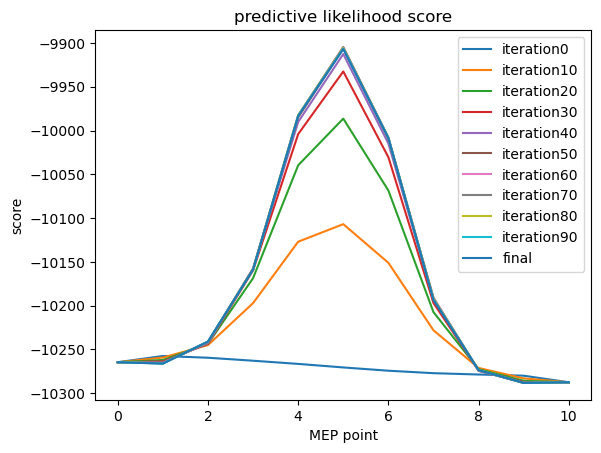

In [81]:
for i in range(len(score_his)):
    if i % 10 == 0:
        plt.plot(score_his[i], label = 'iteration{}'.format(i)) 
plt.plot(score_his[-1], label = 'final')

plt.xlabel("MEP point") 
plt.ylabel("score")
plt.title('predictive likelihood score')
plt.legend()

plt.savefig(PATH + '/Result/pred_score_train1', dpi=600, facecolor='w', transparent=True)